In [9]:
import pandas as pd
import numpy as np
import math
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

In [10]:
df_biketrips = pd.read_csv('biketrips2011-orig.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [3]:
list_holidays = pd.read_csv('days_holidays.csv')['datetime'].values.tolist()
list_workdays = pd.read_csv('days_workingdays.csv')['datetime'].values.tolist()

In [4]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [5]:
# create pivot tables, with each site as a column
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [6]:
# insert rows for missing hours
from datetime import datetime, timedelta

def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

start_date = df_hourly_start.index[0]
end_date = df_hourly_start.index[-1]
#print(daterange(start_date, end_date))
idx_datetime = []
for single_date in daterange(start_date, end_date):
    idx_datetime.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))

df_hourly_start = df_hourly_start.reindex(pd.DatetimeIndex(idx_datetime))
df_hourly_end = df_hourly_end.reindex(pd.DatetimeIndex(idx_datetime))

In [7]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek
df_hourly_start['workday'] = df_hourly_start.index.isin(list_workdays)

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek
df_hourly_end['workday'] = df_hourly_end.index.isin(list_workdays)

df_hourly_start['weekofyear'] = df_hourly_start.index.weekofyear
df_hourly_end['weekofyear'] = df_hourly_end.index.weekofyear

In [12]:
# take off last 4 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-4]

In [10]:
#sample_sites = [31007,31015,31103,31104,31200,31201,31217,31219,31623]
#31007 and 31015 are low volume
sample_sites = [31007,31100,31103,31200,31215]

Site: 31215
Day: 1 Hour: 14 Week: 3
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-25 14:00:00       1.0      0.0  -0.990149 -0.983127     0.509259   
1  2011-02-01 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
2  2011-02-08 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
3  2011-02-15 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
4  2011-02-22 14:00:00       0.0      1.0  -0.986455 -1.014434     0.529080   
5  2011-03-01 14:00:00       0.0      1.0  -0.986455 -1.014434     0.529080   
6  2011-03-08 14:00:00       3.0      3.0  -1.314757 -1.454087    -1.232725   
7  2011-03-15 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
8  2011-03-22 14:00:00       3.0      0.0  -1.314757 -0.983127    -1.232725   
9  2011-03-29 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
10 2011-04-05 14:00:00       0.0      0.0  -0.986455 -0.983127     0.529080   
11 2011-04-12 14

/Users/Derek/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:23: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/Derek/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


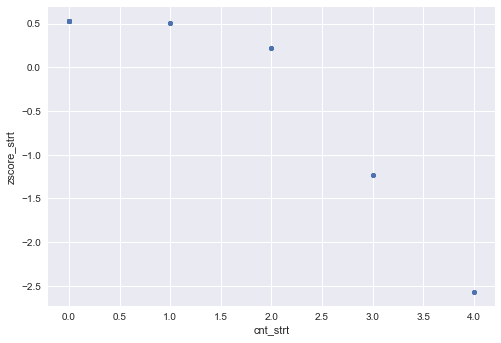

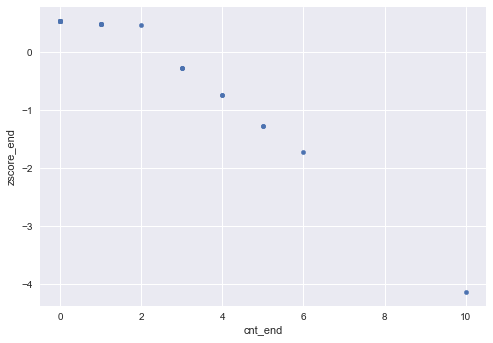

Site: 31704
Day: 0 Hour: 19 Week: 10
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-14 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-03-21 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-03-28 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-04 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-04-11 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-04-18 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-04-25 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-02 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-05-09 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-05-16 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-05-23 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-05-30 1

/Users/Derek/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


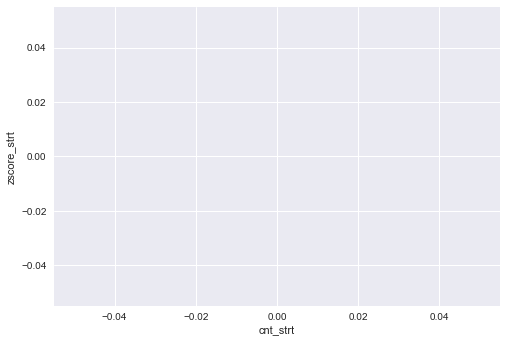

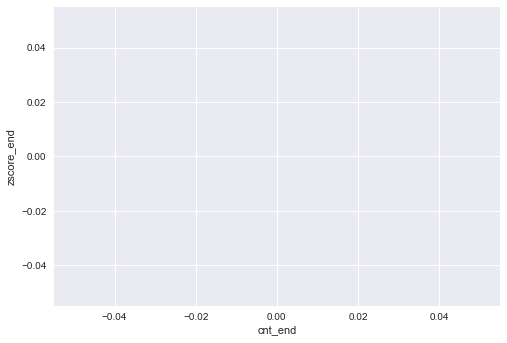

Site: 31502
Day: 2 Hour: 1 Week: 12
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-30 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-06 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-13 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-20 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-04-27 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-04 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-11 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-18 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-05-25 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-01 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-08 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-06-15 01

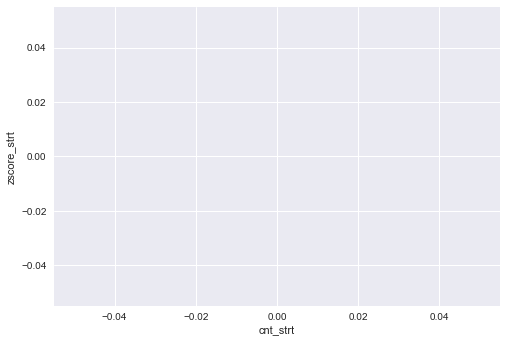

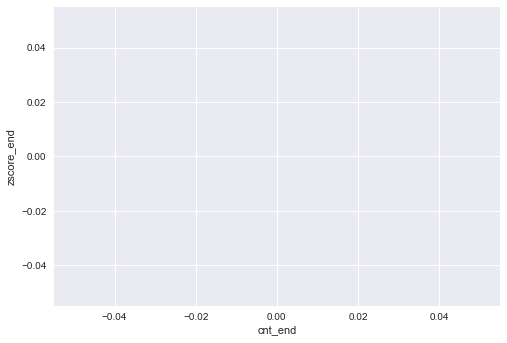

Site: 31019
Day: 6 Hour: 14 Week: 15
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-17 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-24 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-05-01 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-08 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-15 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-22 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-29 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-05 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-12 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-19 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-26 14:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-03 1

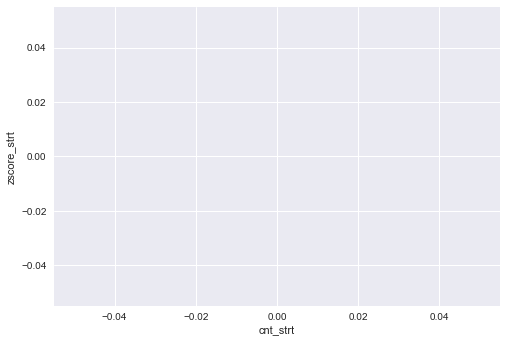

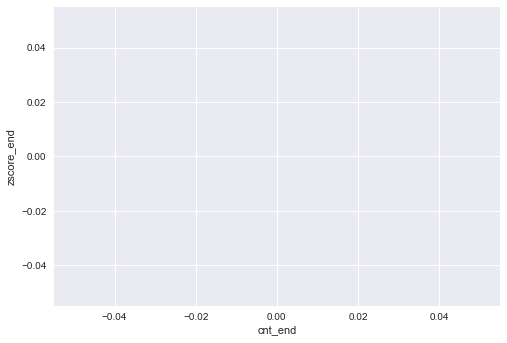

Site: 31708
Day: 4 Hour: 6 Week: 14
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-15 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-22 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-29 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-06 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-13 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-20 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-27 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-03 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-10 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-17 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-24 06:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-01 06

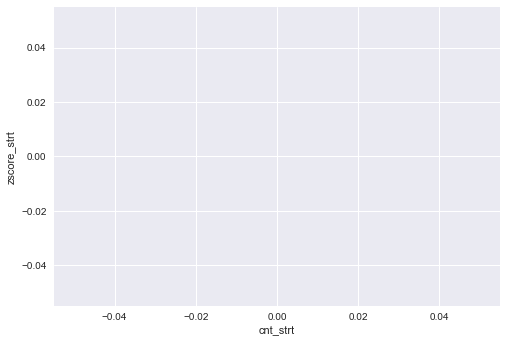

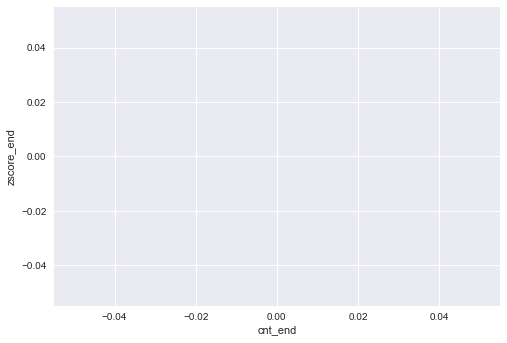

Site: 31225
Day: 6 Hour: 10 Week: 10
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-13 10:00:00       0.0      1.0  -0.963410 -1.014245     0.517636   
1  2011-03-20 10:00:00       1.0      2.0  -0.983679 -0.983838     0.442191   
2  2011-03-27 10:00:00       0.0      1.0  -0.963410 -1.014245     0.517636   
3  2011-04-03 10:00:00       0.0      4.0  -0.963410 -0.955236     0.517636   
4  2011-04-10 10:00:00       3.0      1.0  -0.985778 -1.014245     0.434378   
5  2011-04-17 10:00:00       2.0      2.0  -0.978214 -0.983838     0.462531   
6  2011-04-24 10:00:00       3.0      6.0  -0.985778 -1.044909     0.434378   
7  2011-05-01 10:00:00       5.0      5.0  -1.238546 -0.986909    -0.506504   
8  2011-05-08 10:00:00       7.0      0.0  -1.585703 -1.090263    -1.798729   
9  2011-05-15 10:00:00       3.0      4.0  -0.985778 -0.955236     0.434378   
10 2011-05-22 10:00:00       2.0      7.0  -0.978214 -1.149026     0.462531   
11 2011-05-29 1

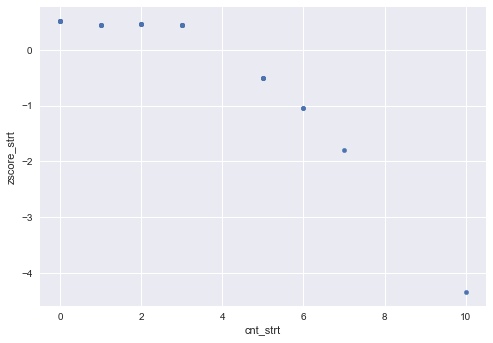

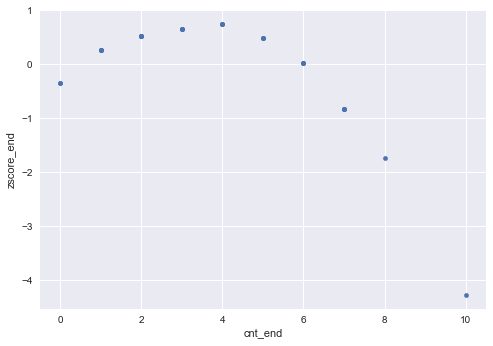

Site: 31111
Day: 1 Hour: 16 Week: 10
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-15 16:00:00       0.0      2.0  -0.972049 -0.966530     0.433940   
1  2011-03-22 16:00:00       1.0      0.0  -0.990681 -1.236725     0.387880   
2  2011-03-29 16:00:00       0.0      4.0  -0.972049 -1.030413     0.433940   
3  2011-04-05 16:00:00       1.0      3.0  -0.990681 -0.955174     0.387880   
4  2011-04-12 16:00:00       0.0      0.0  -0.972049 -1.236725     0.433940   
5  2011-04-19 16:00:00       2.0      3.0  -1.019680 -0.955174     0.316193   
6  2011-04-26 16:00:00       3.0      4.0  -1.359158 -1.030413    -0.523016   
7  2011-05-03 16:00:00       3.0      4.0  -1.359158 -1.030413    -0.523016   
8  2011-05-10 16:00:00       3.0      6.0  -1.359158 -1.358596    -0.523016   
9  2011-05-17 16:00:00       1.0      4.0  -0.990681 -1.030413     0.387880   
10 2011-05-24 16:00:00       0.0      3.0  -0.972049 -0.955174     0.433940   
11 2011-05-31 1

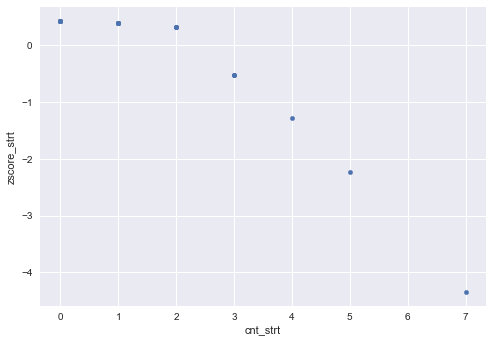

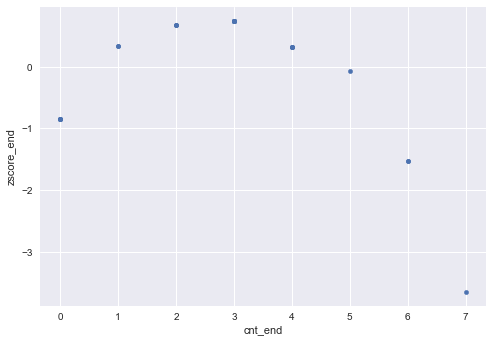

Site: 31209
Day: 2 Hour: 13 Week: 16
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-04-27 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-05-04 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-05-11 13:00:00       0.0      1.0 -1.000000e+00 -9.000000e+09   
3  2011-05-18 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-05-25 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-06-01 13:00:00       0.0     12.0 -1.000000e+00 -9.240000e+10   
6  2011-06-08 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-06-15 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-06-22 13:00:00       1.0      0.0 -9.000000e+09 -1.000000e+00   
9  2011-06-29 13:00:00       1.0      1.0 -9.000000e+09 -9.000000e+09   
10 2011-07-06 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-07-13 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-07-20 

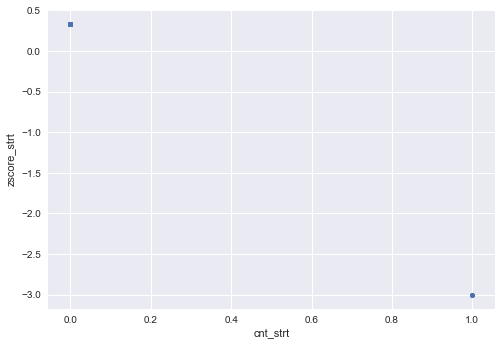

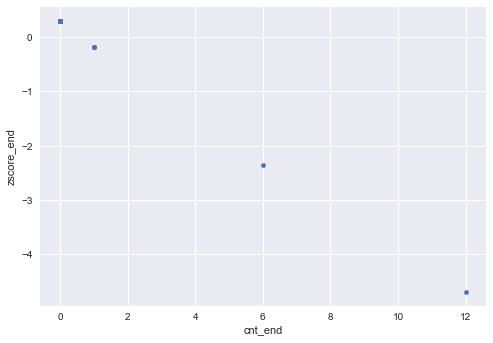

Site: 31501
Day: 5 Hour: 19 Week: 2
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-01-15 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-01-22 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-01-29 19:00:00       1.0      0.0 -8.400000e+09 -1.000000e+00   
3  2011-02-05 19:00:00       1.0      1.0 -8.400000e+09 -8.400000e+09   
4  2011-02-12 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-02-19 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-02-26 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-05 19:00:00       0.0      1.0 -1.000000e+00 -8.400000e+09   
8  2011-03-12 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-03-19 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-03-26 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-02 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-04-09 1

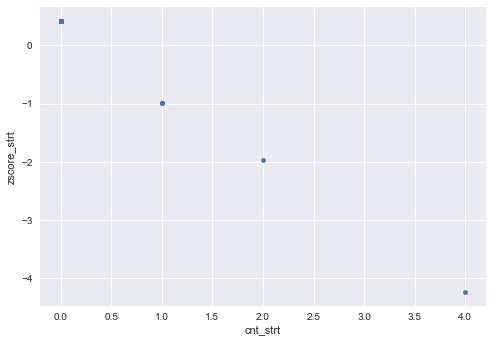

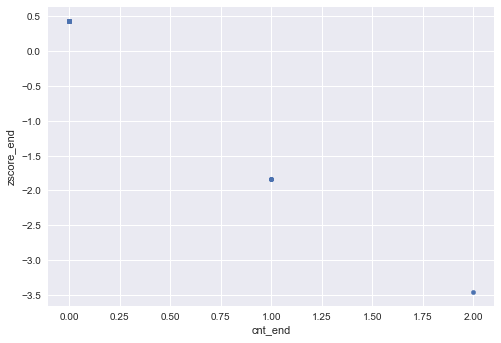

Site: 31806
Day: 5 Hour: 21 Week: 1
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-08 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-01-15 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-01-22 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-01-29 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-02-05 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-02-12 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-02-19 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-02-26 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-03-05 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-03-12 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-03-19 21:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-03-26 21

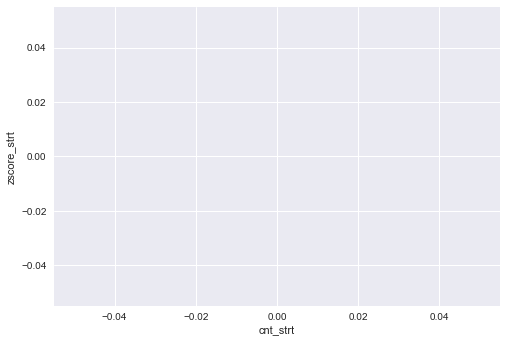

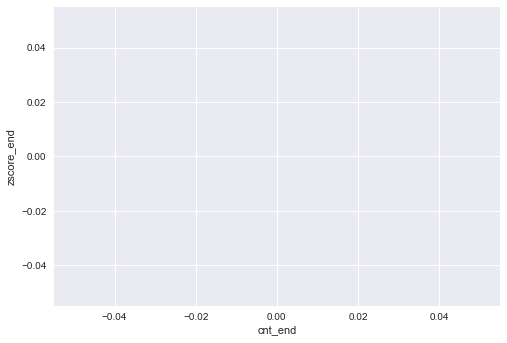

Site: 31005
Day: 3 Hour: 16 Week: 13
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-04-07 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
1  2011-04-14 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
2  2011-04-21 16:00:00       0.0      1.0 -1.000000e+00 -1.018333   
3  2011-04-28 16:00:00       0.0      1.0 -1.000000e+00 -1.018333   
4  2011-05-05 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
5  2011-05-12 16:00:00       0.0      1.0 -1.000000e+00 -1.018333   
6  2011-05-19 16:00:00       4.0      0.0 -2.812500e+10 -0.986364   
7  2011-05-26 16:00:00       1.0      1.0 -8.000000e+09 -1.018333   
8  2011-06-02 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
9  2011-06-09 16:00:00       1.0      0.0 -8.000000e+09 -0.986364   
10 2011-06-16 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
11 2011-06-23 16:00:00       0.0      0.0 -1.000000e+00 -0.986364   
12 2011-06-30 16:00:00       0.0      0.0 -1.000000e+00 -0.986364 

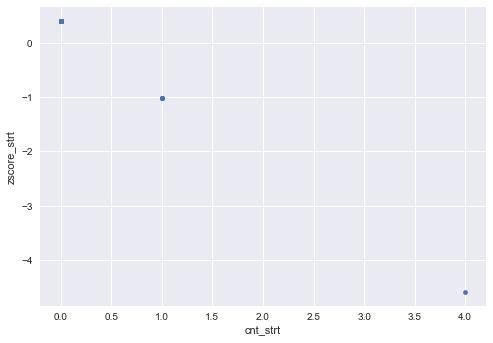

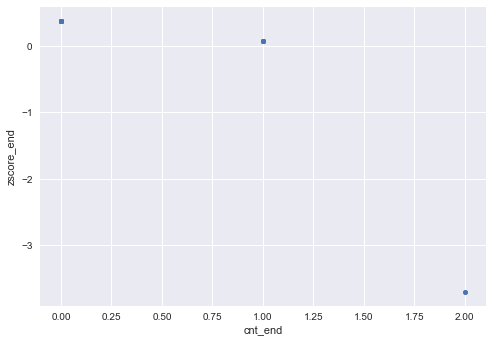

Site: 31303
Day: 0 Hour: 20 Week: 3
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-24 20:00:00       0.0      0.0  -0.966629 -1.140670     0.492038   
1  2011-01-31 20:00:00       0.0      1.0  -0.966629 -0.978561     0.492038   
2  2011-02-07 20:00:00       0.0      1.0  -0.966629 -0.978561     0.492038   
3  2011-02-14 20:00:00       0.0      0.0  -0.966629 -1.140670     0.492038   
4  2011-02-21 20:00:00       0.0      0.0  -0.966629 -1.140670     0.492038   
5  2011-02-28 20:00:00       0.0      0.0  -0.966629 -1.140670     0.492038   
6  2011-03-07 20:00:00       0.0      0.0  -0.966629 -1.140670     0.492038   
7  2011-03-14 20:00:00       0.0      1.0  -0.966629 -0.978561     0.492038   
8  2011-03-21 20:00:00       1.0      2.0  -0.989510 -0.936979     0.395471   
9  2011-03-28 20:00:00       1.0      2.0  -0.989510 -0.936979     0.395471   
10 2011-04-04 20:00:00       1.0      1.0  -0.989510 -0.978561     0.395471   
11 2011-04-11 20

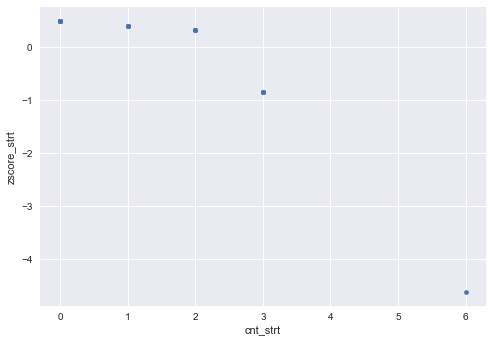

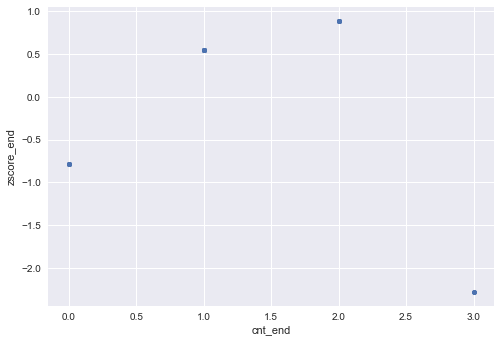

Site: 31804
Day: 2 Hour: 1 Week: 8
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-02 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-03-09 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-03-16 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-03-23 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-30 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-04-06 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-04-13 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-04-20 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-27 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-05-04 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-05-11 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-05-18 01:

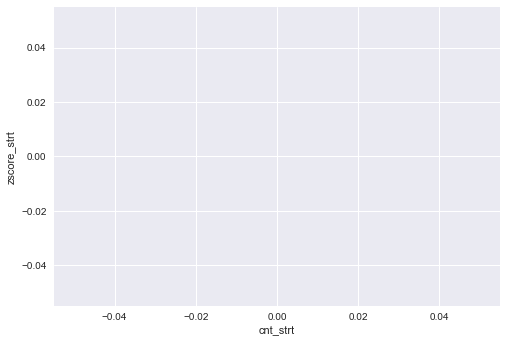

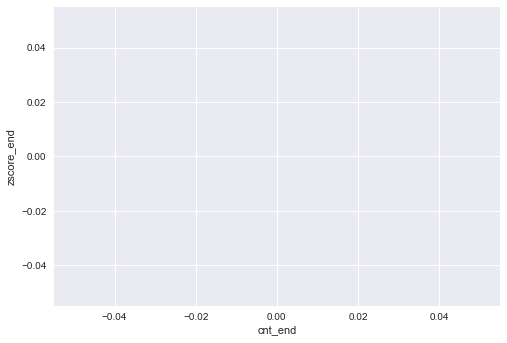

Site: 31004
Day: 0 Hour: 23 Week: 5
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-02-07 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-02-14 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-02-21 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-02-28 23:00:00       1.0      1.0 -9.500000e+09 -8.000000e+09   
4  2011-03-07 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-03-14 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-03-21 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-28 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-04-04 23:00:00       0.0      1.0 -1.000000e+00 -8.000000e+09   
9  2011-04-11 23:00:00       1.0      1.0 -9.500000e+09 -8.000000e+09   
10 2011-04-18 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-25 23:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-05-02 2

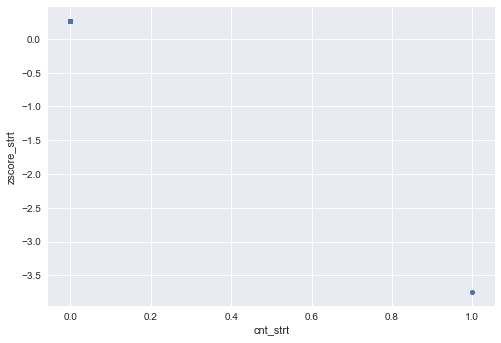

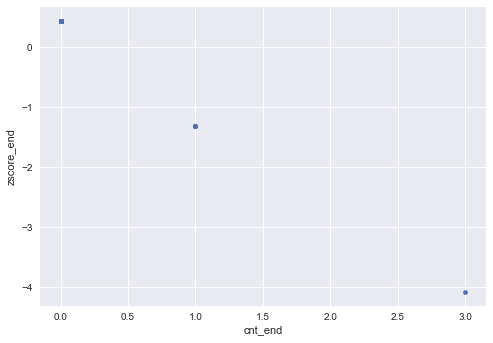

Site: 31013
Day: 1 Hour: 12 Week: 20
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-05-24 12:00:00       0.0      1.0 -1.000000e+00 -6.825000e+09   
1  2011-05-31 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-06-07 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-06-14 12:00:00       1.0      1.0 -9.350000e+09 -6.825000e+09   
4  2011-06-21 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-06-28 12:00:00       2.0      1.0 -1.520000e+10 -6.825000e+09   
6  2011-07-05 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-07-12 12:00:00       0.0      1.0 -1.000000e+00 -6.825000e+09   
8  2011-07-19 12:00:00       0.0      1.0 -1.000000e+00 -6.825000e+09   
9  2011-07-26 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-08-02 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-08-09 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-08-16 

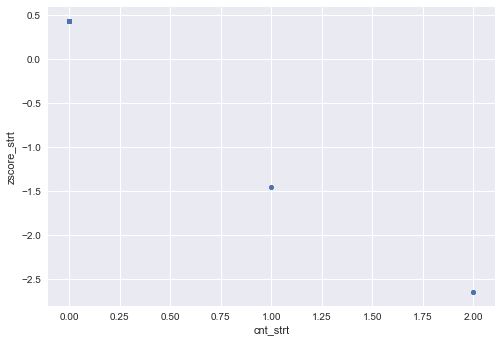

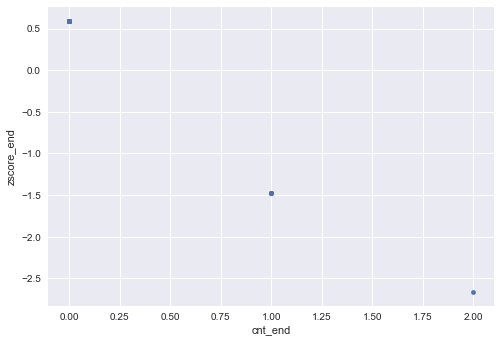

Site: 31116
Day: 0 Hour: 15 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-07 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-14 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-21 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-02-28 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-07 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-14 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-21 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-28 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-04 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-11 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-18 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-25 15

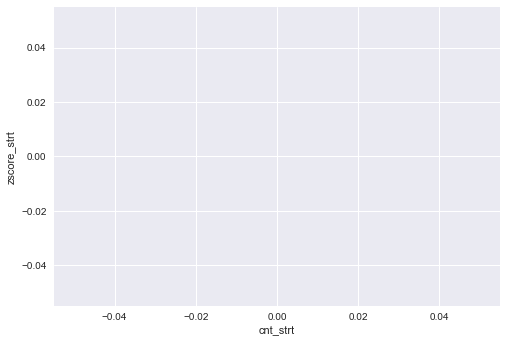

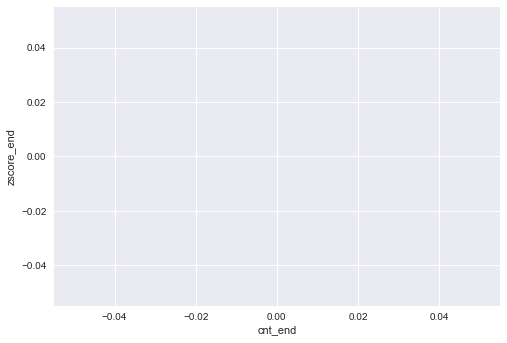

Site: 31017
Day: 2 Hour: 5 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-06 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-13 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-20 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-27 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-04 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-11 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-18 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-25 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-01 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-08 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-15 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-06-22 05

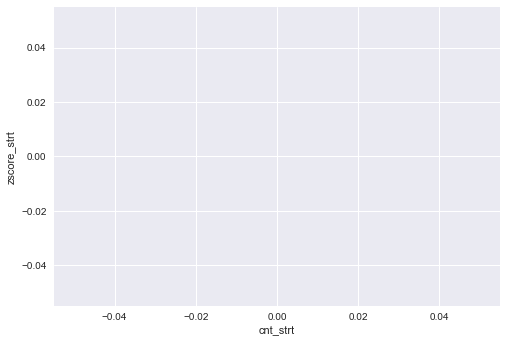

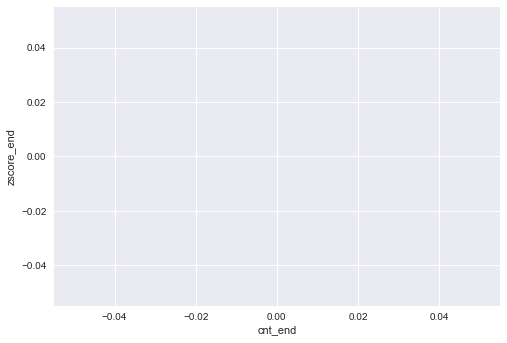

Site: 31224
Day: 2 Hour: 12 Week: 2
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-19 12:00:00       1.0      4.0  -1.033171 -1.429773     0.099391   
1  2011-01-26 12:00:00       1.0      1.0  -1.033171 -1.003333     0.099391   
2  2011-02-02 12:00:00       1.0      1.0  -1.033171 -1.003333     0.099391   
3  2011-02-09 12:00:00       1.0      5.0  -1.033171 -1.725727     0.099391   
4  2011-02-16 12:00:00       2.0      1.0  -0.933172 -1.003333     0.583086   
5  2011-02-23 12:00:00       1.0      2.0  -1.033171 -0.959182     0.099391   
6  2011-03-02 12:00:00       0.0      0.0  -1.033171 -0.969355     0.099391   
7  2011-03-09 12:00:00       0.0      4.0  -1.033171 -1.429773     0.099391   
8  2011-03-16 12:00:00       2.0      2.0  -0.933172 -0.959182     0.583086   
9  2011-03-23 12:00:00       0.0      1.0  -1.033171 -1.003333     0.099391   
10 2011-03-30 12:00:00       1.0      1.0  -1.033171 -1.003333     0.099391   
11 2011-04-06 12

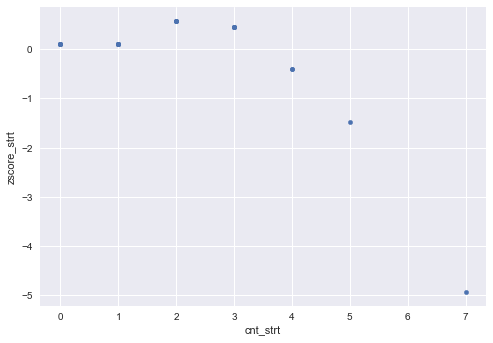

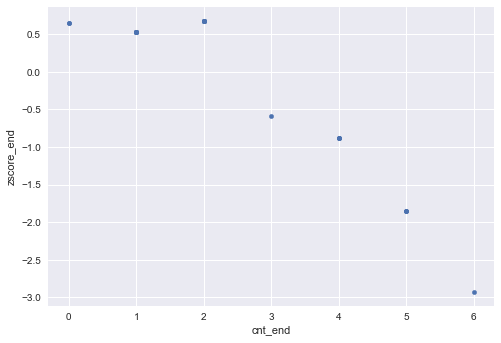

Site: 31400
Day: 4 Hour: 8 Week: 21
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-06-03 08:00:00      11.0      2.0  -1.223703 -1.370130    -0.769731   
1  2011-06-10 08:00:00      12.0      3.0  -1.409749 -2.035815    -1.786348   
2  2011-06-17 08:00:00       9.0      0.0  -1.009034 -0.967391     0.403288   
3  2011-06-24 08:00:00       7.0      1.0  -0.959064 -1.025312     0.676337   
4  2011-07-01 08:00:00       8.0      2.0  -0.995821 -1.370130     0.475485   
5  2011-07-08 08:00:00       9.0      0.0  -1.009034 -0.967391     0.403288   
6  2011-07-15 08:00:00       8.0      0.0  -0.995821 -0.967391     0.475485   
7  2011-07-22 08:00:00       5.0      0.0  -0.960976 -0.967391     0.665893   
8  2011-07-29 08:00:00       5.0      1.0  -0.960976 -1.025312     0.665893   
9  2011-08-05 08:00:00       6.0      0.0  -0.958680 -0.967391     0.678435   
10 2011-08-12 08:00:00       8.0      2.0  -0.995821 -1.370130     0.475485   
11 2011-08-19 08

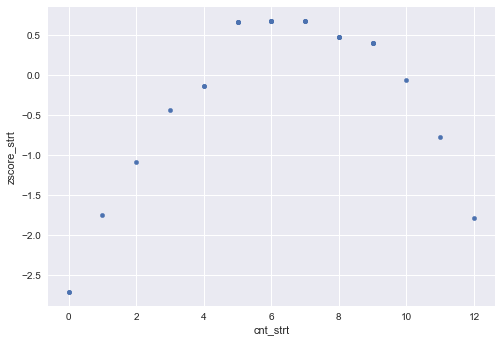

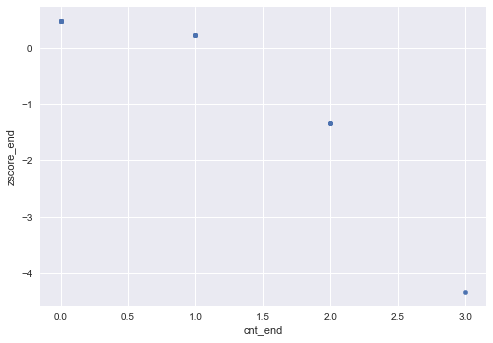

Site: 31215
Day: 4 Hour: 20 Week: 17
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-06 20:00:00       1.0      1.0  -1.003721 -0.980627     0.456225   
1  2011-05-13 20:00:00       0.0      4.0  -0.983753 -1.091479     0.533227   
2  2011-05-20 20:00:00       1.0      3.0  -1.003721 -0.988863     0.456225   
3  2011-05-27 20:00:00       0.0      2.0  -0.983753 -1.003867     0.533227   
4  2011-06-03 20:00:00       0.0      7.0  -0.983753 -1.629161     0.533227   
5  2011-06-10 20:00:00       3.0      7.0  -1.330880 -1.629161    -0.805401   
6  2011-06-17 20:00:00       3.0      1.0  -1.330880 -0.980627    -0.805401   
7  2011-06-24 20:00:00       6.0      3.0  -2.197038 -0.988863    -4.145575   
8  2011-07-01 20:00:00       4.0      2.0  -1.604413 -1.003867    -1.860228   
9  2011-07-08 20:00:00       3.0      4.0  -1.330880 -1.091479    -0.805401   
10 2011-07-15 20:00:00       3.0      2.0  -1.330880 -1.003867    -0.805401   
11 2011-07-22 2

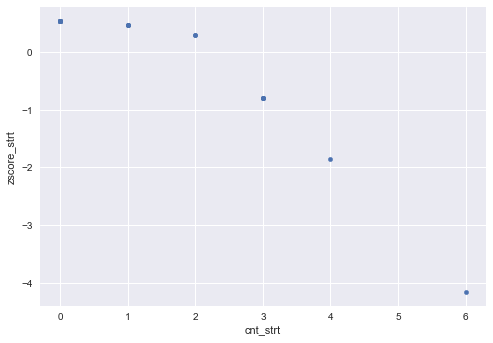

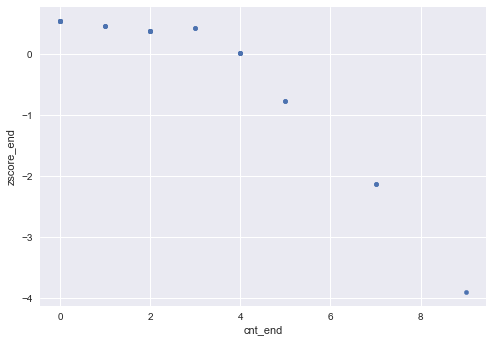

Site: 31504
Day: 5 Hour: 0 Week: 16
     datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  zscore_strt  \
0  2011-04-23       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
1  2011-04-30       2.0      0.0 -1.852500e+10 -1.000000e+00    -4.719120   
2  2011-05-07       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
3  2011-05-14       0.0      1.0 -1.000000e+00 -9.000000e+09     0.255323   
4  2011-05-21       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
5  2011-05-28       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
6  2011-06-04       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
7  2011-06-11       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
8  2011-06-18       0.0      1.0 -1.000000e+00 -9.000000e+09     0.255323   
9  2011-06-25       0.0      1.0 -1.000000e+00 -9.000000e+09     0.255323   
10 2011-07-02       0.0      0.0 -1.000000e+00 -1.000000e+00     0.255323   
11 2011-07-09       0.0      0.0 -1.0000

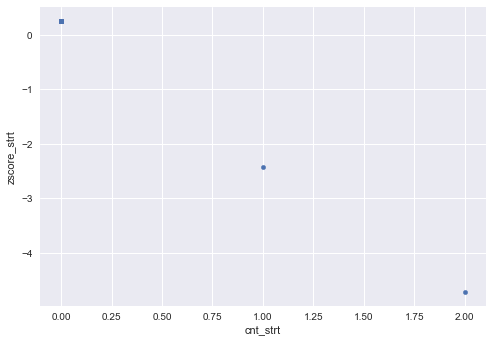

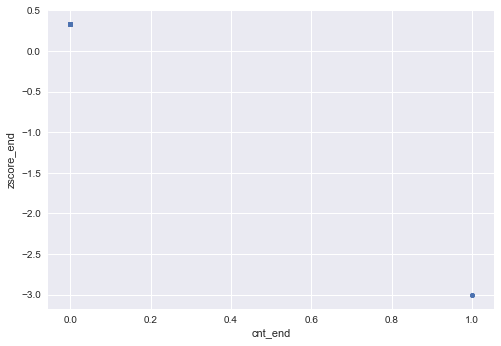

Site: 31212
Day: 4 Hour: 1 Week: 1
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-01-14 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-01-21 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-01-28 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-02-04 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-02-11 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-02-18 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-02-25 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-04 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-03-11 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-03-18 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-03-25 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-01 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-04-08 01

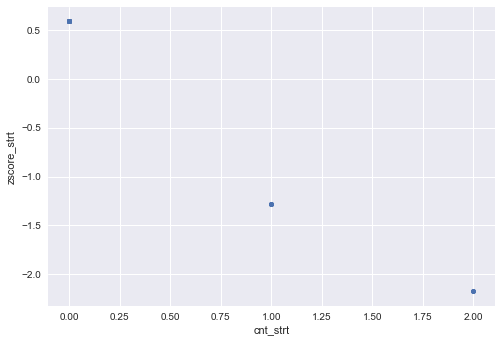

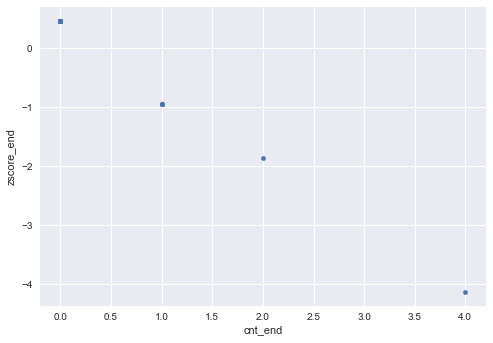

Site: 31609
Day: 6 Hour: 14 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-03 14:00:00       7.0      4.0  -1.640591 -0.973234    -2.609662   
1  2011-04-10 14:00:00       2.0      0.0  -0.997926 -1.025578     0.403850   
2  2011-04-17 14:00:00       6.0      8.0  -1.414017 -1.702009    -1.547237   
3  2011-04-24 14:00:00       3.0      7.0  -0.984259 -1.503668     0.467939   
4  2011-05-01 14:00:00       3.0      0.0  -0.984259 -1.025578     0.467939   
5  2011-05-08 14:00:00       5.0      5.0  -1.274587 -1.173100    -0.893436   
6  2011-05-15 14:00:00       0.0      6.0  -0.975811 -1.338384     0.507551   
7  2011-05-22 14:00:00       3.0      1.0  -0.984259 -0.987838     0.467939   
8  2011-05-29 14:00:00       4.0      5.0  -1.099096 -1.173100    -0.070543   
9  2011-06-05 14:00:00       2.0      2.0  -0.997926 -0.986203     0.403850   
10 2011-06-12 14:00:00       1.0      3.0  -0.995925 -0.941869     0.413235   
11 2011-06-19 1

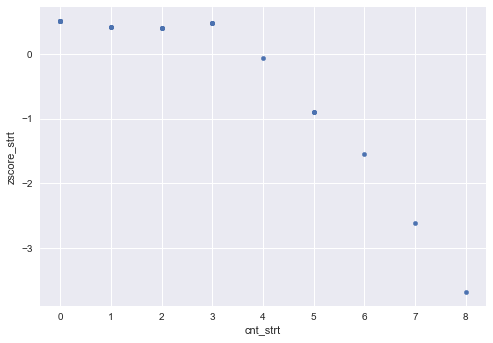

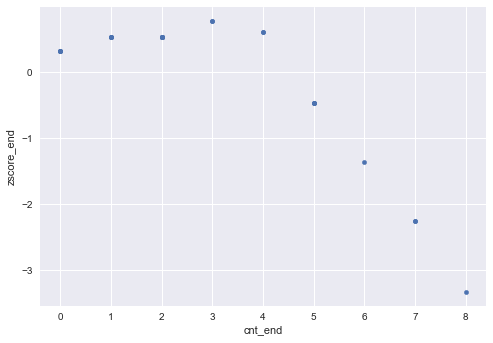

Site: 31003
Day: 3 Hour: 6 Week: 9
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-03-10 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
1  2011-03-17 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
2  2011-03-24 06:00:00       1.0      0.0  -1.028966 -1.000000e+00   
3  2011-03-31 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
4  2011-04-07 06:00:00       1.0      0.0  -1.028966 -1.000000e+00   
5  2011-04-14 06:00:00       1.0      0.0  -1.028966 -1.000000e+00   
6  2011-04-21 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
7  2011-04-28 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
8  2011-05-05 06:00:00       0.0      0.0  -1.085962 -1.000000e+00   
9  2011-05-12 06:00:00       2.0      0.0  -0.873077 -1.000000e+00   
10 2011-05-19 06:00:00       0.0      1.0  -1.085962 -9.500000e+09   
11 2011-05-26 06:00:00       1.0      0.0  -1.028966 -1.000000e+00   
12 2011-06-02 06:00:00       2.0      0.0  -0.873077 -1

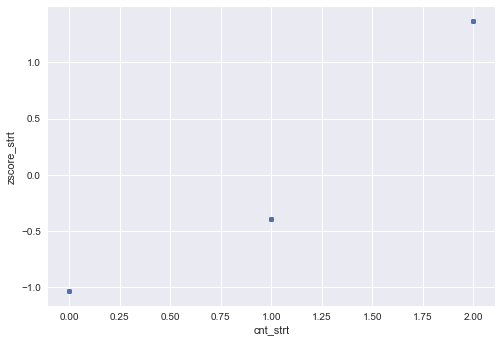

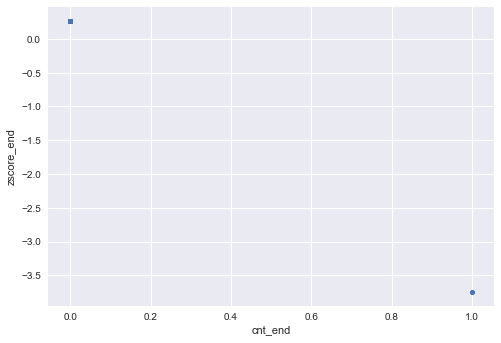

Site: 31602
Day: 0 Hour: 18 Week: 21
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-30 18:00:00       6.0      2.0  -1.000193 -1.158865     0.333871   
1  2011-06-06 18:00:00       3.0      5.0  -1.300290 -0.986170    -0.601236   
2  2011-06-13 18:00:00       6.0     12.0  -1.000193 -1.122145     0.333871   
3  2011-06-20 18:00:00       7.0     10.0  -0.955385 -1.081375     0.473492   
4  2011-06-27 18:00:00      17.0     13.0  -2.667478 -1.203686    -4.861410   
5  2011-07-04 18:00:00       9.0      4.0  -0.980372 -1.007757     0.395634   
6  2011-07-11 18:00:00       6.0      8.0  -1.000193 -0.934145     0.333871   
7  2011-07-18 18:00:00      11.0      5.0  -1.205766 -0.986170    -0.306697   
8  2011-07-25 18:00:00       9.0      9.0  -0.980372 -0.971024     0.395634   
9  2011-08-01 18:00:00      10.0     14.0  -1.093069 -1.315804     0.044468   
10 2011-08-08 18:00:00      12.0     10.0  -1.418063 -1.081375    -0.968216   
11 2011-08-15 1

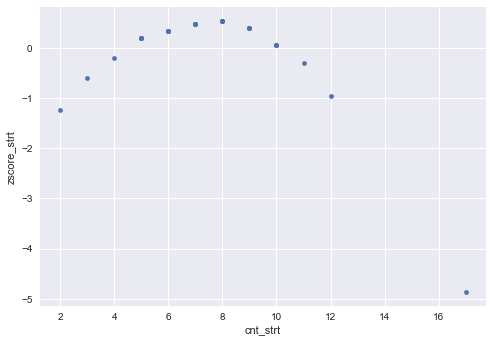

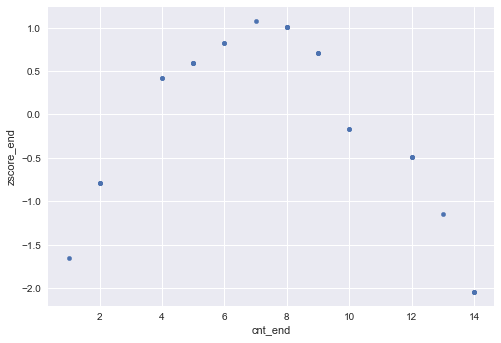

Site: 31605
Day: 1 Hour: 18 Week: 20
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-24 18:00:00       5.0      6.0  -0.982560 -0.945537     0.555565   
1  2011-05-31 18:00:00       7.0      6.0  -0.936883 -0.945537     0.896549   
2  2011-06-07 18:00:00      12.0     10.0  -1.335713 -1.172475    -2.080736   
3  2011-06-14 18:00:00       7.0      8.0  -0.936883 -1.004884     0.896549   
4  2011-06-21 18:00:00       6.0      8.0  -0.969893 -1.004884     0.650123   
5  2011-06-28 18:00:00      11.0     10.0  -1.177346 -1.172475    -0.898517   
6  2011-07-05 18:00:00       9.0      4.0  -1.038363 -1.060728     0.138995   
7  2011-07-12 18:00:00       7.0      5.0  -0.936883 -1.002366     0.896549   
8  2011-07-19 18:00:00       5.0      8.0  -0.982560 -1.004884     0.555565   
9  2011-07-26 18:00:00      11.0      9.0  -1.177346 -1.019953    -0.898517   
10 2011-08-02 18:00:00      10.0      6.0  -1.124557 -0.945537    -0.504444   
11 2011-08-09 1

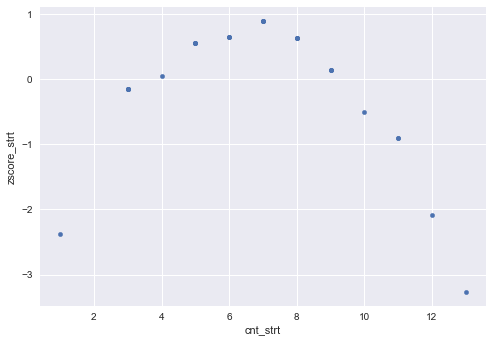

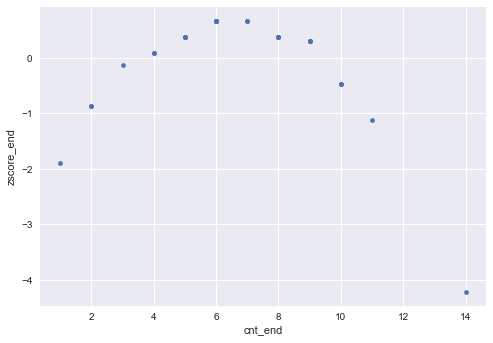

Site: 31201
Day: 0 Hour: 17 Week: 2
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-17 17:00:00       3.0      2.0  -0.984106 -1.155221     0.512466   
1  2011-01-24 17:00:00       3.0     10.0  -0.984106 -0.964065     0.512466   
2  2011-01-31 17:00:00       5.0      7.0  -0.972487 -1.028706     0.554881   
3  2011-02-07 17:00:00       7.0      9.0  -0.974959 -0.957305     0.545857   
4  2011-02-14 17:00:00       8.0     12.0  -0.989785 -0.943145     0.491735   
5  2011-02-21 17:00:00       5.0      1.0  -0.972487 -1.215149     0.554881   
6  2011-02-28 17:00:00       1.0      2.0  -1.123536 -1.155221     0.003493   
7  2011-03-07 17:00:00       5.0     11.0  -0.972487 -0.942754     0.554881   
8  2011-03-14 17:00:00       5.0     16.0  -0.972487 -1.051443     0.554881   
9  2011-03-21 17:00:00       4.0      8.0  -0.995725 -1.003160     0.470052   
10 2011-03-28 17:00:00       3.0      4.0  -0.984106 -1.062000     0.512466   
11 2011-04-04 17

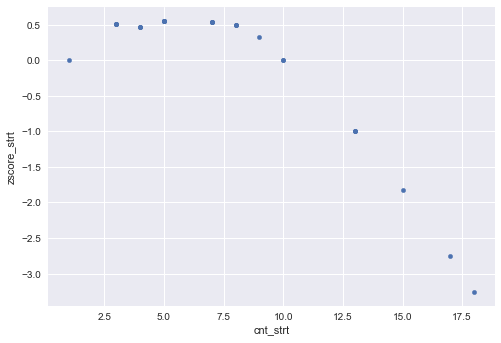

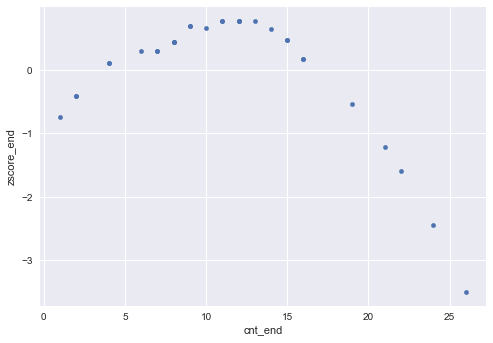

Site: 31022
Day: 3 Hour: 1 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-10 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-17 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-24 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-03-03 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-10 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-17 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-24 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-31 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-07 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-14 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-21 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-28 01:

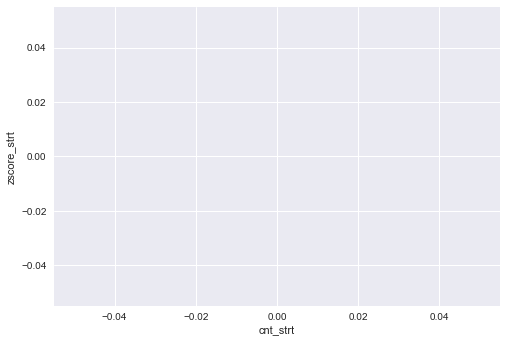

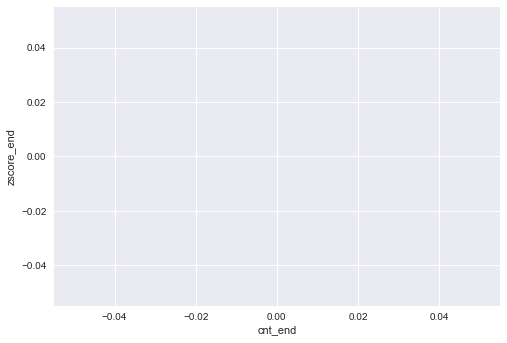

Site: 31500
Day: 2 Hour: 5 Week: 6
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-02-16 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
1  2011-02-23 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
2  2011-03-02 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
3  2011-03-09 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
4  2011-03-16 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
5  2011-03-23 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
6  2011-03-30 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
7  2011-04-06 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
8  2011-04-13 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
9  2011-04-20 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
10 2011-04-27 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
11 2011-05-04 05:00:00       0.0      0.0 -1.000000e+00      -1.0   
12 2011-05-11 05:00:00       0.0      0.0 -1.000000e+00      -1.0   

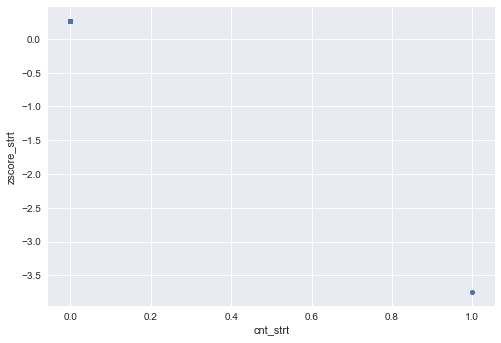

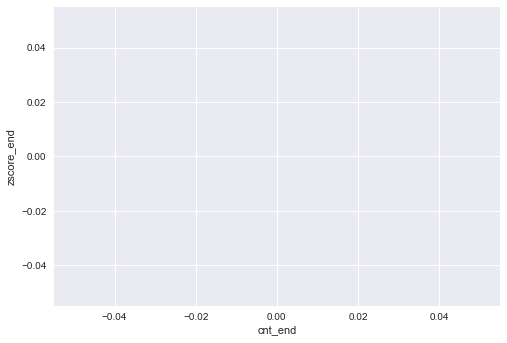

Site: 31226
Day: 1 Hour: 6 Week: 18
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-10 06:00:00       0.0      0.0  -1.000000 -0.976190     0.302364   
1  2011-05-17 06:00:00       0.0      0.0  -1.000000 -0.976190     0.302364   
2  2011-05-24 06:00:00       1.0      1.0  -1.000000 -1.003152     0.302364   
3  2011-05-31 06:00:00       0.0      0.0  -1.000000 -0.976190     0.302364   
4  2011-06-07 06:00:00       1.0      0.0  -1.000000 -0.976190     0.302364   
5  2011-06-14 06:00:00       0.0      0.0  -1.000000 -0.976190     0.302364   
6  2011-06-21 06:00:00       2.0      1.0  -1.613333 -1.003152    -1.780043   
7  2011-06-28 06:00:00       1.0      1.0  -1.000000 -1.003152     0.302364   
8  2011-07-05 06:00:00       0.0      1.0  -1.000000 -1.003152     0.302364   
9  2011-07-12 06:00:00       1.0      1.0  -1.000000 -1.003152     0.302364   
10 2011-07-19 06:00:00       3.0      1.0  -2.445000 -1.003152    -4.603742   
11 2011-07-26 06

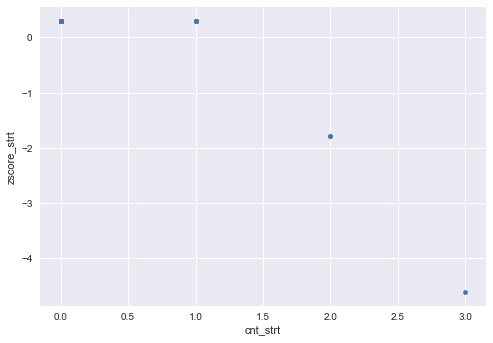

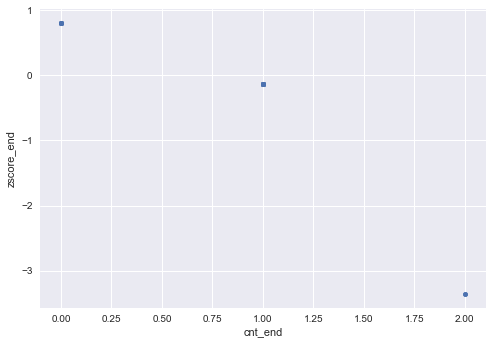

Site: 31214
Day: 0 Hour: 21 Week: 12
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-28 21:00:00       3.0      2.0  -0.993874 -1.356247     0.371256   
1  2011-04-04 21:00:00       6.0      3.0  -0.983334 -1.196775     0.426095   
2  2011-04-11 21:00:00       3.0      5.0  -0.993874 -1.014816     0.371256   
3  2011-04-18 21:00:00       2.0      5.0  -1.070629 -1.014816    -0.028130   
4  2011-04-25 21:00:00       6.0     11.0  -0.983334 -1.206281     0.426095   
5  2011-05-02 21:00:00       6.0      6.0  -0.983334 -0.964574     0.426095   
6  2011-05-09 21:00:00       5.0     14.0  -0.936861 -1.819466     0.667912   
7  2011-05-16 21:00:00       2.0      3.0  -1.070629 -1.196775    -0.028130   
8  2011-05-23 21:00:00       1.0      1.0  -1.193438 -1.544713    -0.667149   
9  2011-05-30 21:00:00       4.0      7.0  -0.959976 -0.954744     0.547640   
10 2011-06-06 21:00:00       8.0      8.0  -1.051410 -0.978408     0.071872   
11 2011-06-13 2

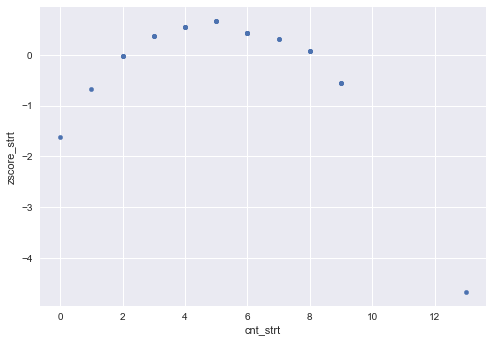

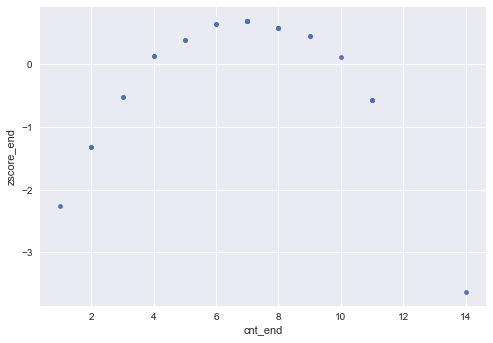

Site: 31225
Day: 2 Hour: 6 Week: 21
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-06-01 06:00:00       0.0      2.0 -1.000000e+00 -1.434286   
1  2011-06-08 06:00:00       0.0      1.0 -1.000000e+00 -1.011371   
2  2011-06-15 06:00:00       0.0      0.0 -1.000000e+00 -0.990476   
3  2011-06-22 06:00:00       0.0      0.0 -1.000000e+00 -0.990476   
4  2011-06-29 06:00:00       1.0      1.0 -8.500000e+09 -1.011371   
5  2011-07-06 06:00:00       0.0      1.0 -1.000000e+00 -1.011371   
6  2011-07-13 06:00:00       1.0      1.0 -8.500000e+09 -1.011371   
7  2011-07-20 06:00:00       1.0      0.0 -8.500000e+09 -0.990476   
8  2011-07-27 06:00:00       0.0      0.0 -1.000000e+00 -0.990476   
9  2011-08-03 06:00:00       0.0      0.0 -1.000000e+00 -0.990476   
10 2011-08-10 06:00:00       0.0      1.0 -1.000000e+00 -1.011371   
11 2011-08-17 06:00:00       2.0      2.0 -1.440000e+10 -1.434286   
12 2011-08-24 06:00:00       0.0      2.0 -1.000000e+00 -1.434286  

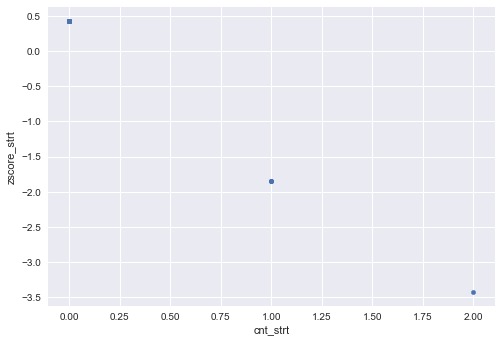

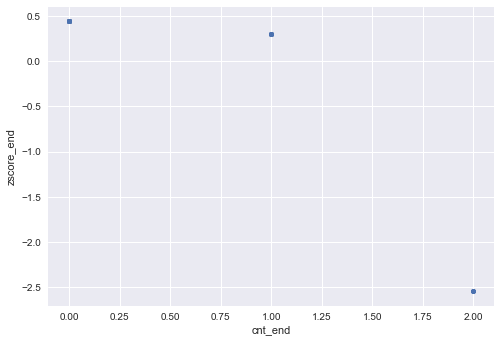

Site: 31401
Day: 5 Hour: 0 Week: 15
     datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  zscore_end
0  2011-04-16       0.0      2.0  -0.983333 -0.986473     0.493058    0.304048
1  2011-04-23       1.0      1.0  -1.005882 -0.931629     0.430292    0.449215
2  2011-04-30       1.0      2.0  -1.005882 -0.986473     0.430292    0.304048
3  2011-05-07       0.0      2.0  -0.983333 -0.986473     0.493058    0.304048
4  2011-05-14       1.0      2.0  -1.005882 -0.986473     0.430292    0.304048
5  2011-05-21       3.0      2.0  -2.034034 -0.986473    -2.431606    0.304048
6  2011-05-28       0.0      3.0  -0.983333 -1.098641     0.493058    0.007152
7  2011-06-04       0.0      3.0  -0.983333 -1.098641     0.493058    0.007152
8  2011-06-11       1.0      2.0  -1.005882 -0.986473     0.430292    0.304048
9  2011-06-18       1.0      2.0  -1.005882 -0.986473     0.430292    0.304048
10 2011-06-25       0.0      2.0  -0.983333 -0.986473     0.493058    0.304048
11 2011-07-02   

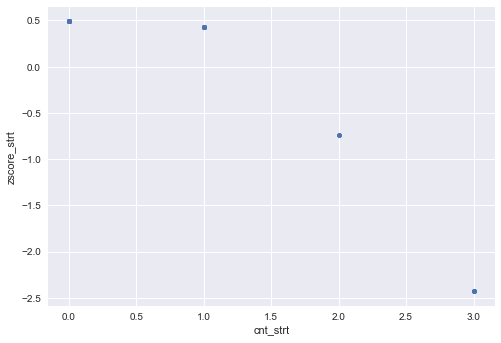

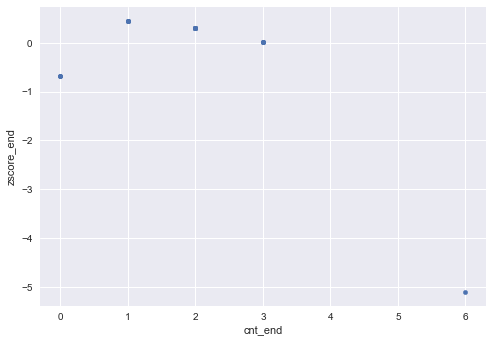

Site: 31708
Day: 0 Hour: 20 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-07 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-14 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-21 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-02-28 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-07 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-14 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-21 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-28 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-04 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-11 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-18 20:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-25 20

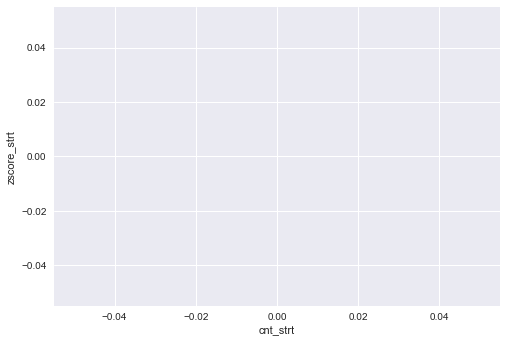

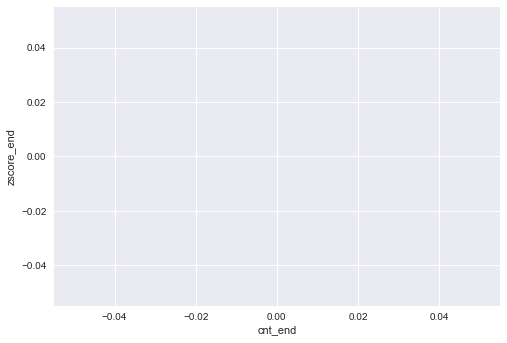

Site: 31011
Day: 3 Hour: 8 Week: 8
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-03 08:00:00       0.0      3.0  -0.985938 -0.964559     0.336592   
1  2011-03-10 08:00:00       0.0      0.0  -0.985938 -1.155226     0.336592   
2  2011-03-17 08:00:00       0.0      0.0  -0.985938 -1.155226     0.336592   
3  2011-03-24 08:00:00       0.0      1.0  -0.985938 -1.004573     0.336592   
4  2011-03-31 08:00:00       0.0      1.0  -0.985938 -1.004573     0.336592   
5  2011-04-07 08:00:00       0.0      1.0  -0.985938 -1.004573     0.336592   
6  2011-04-14 08:00:00       0.0      2.0  -0.985938 -0.981321     0.336592   
7  2011-04-21 08:00:00       1.0      2.0  -1.019355 -0.981321     0.163578   
8  2011-04-28 08:00:00       5.0      4.0  -1.957457 -1.037936    -4.693324   
9  2011-05-05 08:00:00       0.0      3.0  -0.985938 -0.964559     0.336592   
10 2011-05-12 08:00:00       1.0      2.0  -1.019355 -0.981321     0.163578   
11 2011-05-19 08:

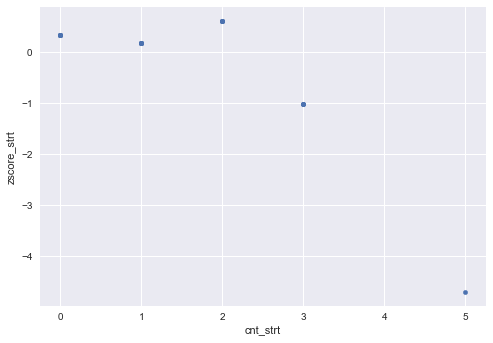

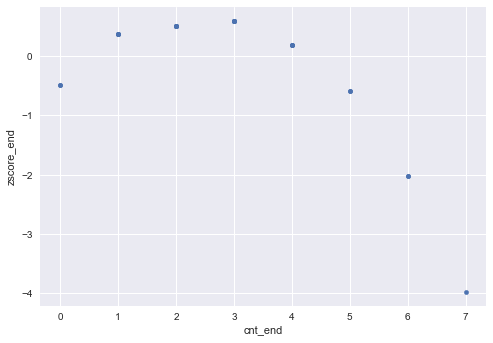

Site: 31615
Day: 3 Hour: 15 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-10 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-17 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-24 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-03-03 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-10 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-17 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-24 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-31 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-07 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-14 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-21 15:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-28 15

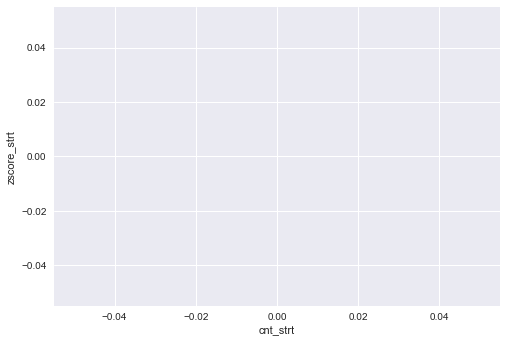

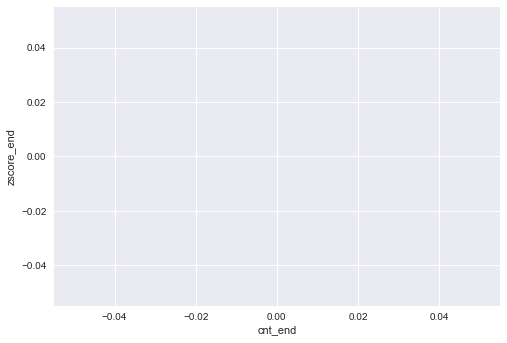

Site: 31307
Day: 3 Hour: 23 Week: 0
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-06 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-01-13 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-01-20 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-01-27 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-02-03 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-02-10 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-02-17 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-02-24 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-03-03 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-03-10 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-03-17 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-03-24 23

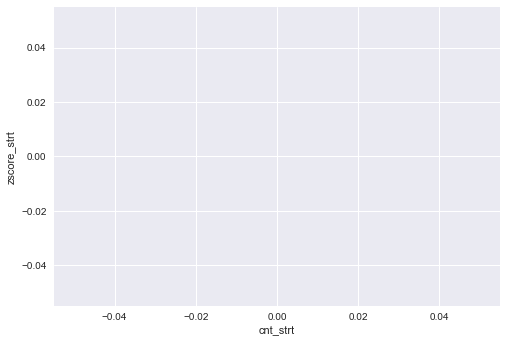

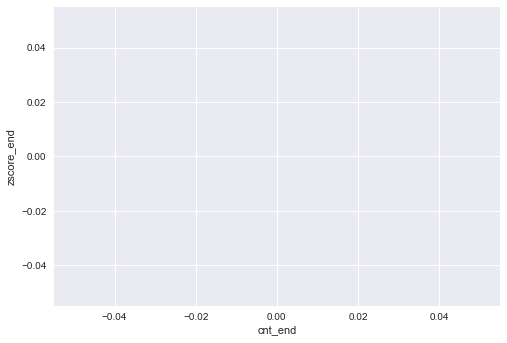

Site: 31021
Day: 5 Hour: 1 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-05 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-12 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-19 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-02-26 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-05 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-12 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-19 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-26 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-02 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-09 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-16 01:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-23 01:

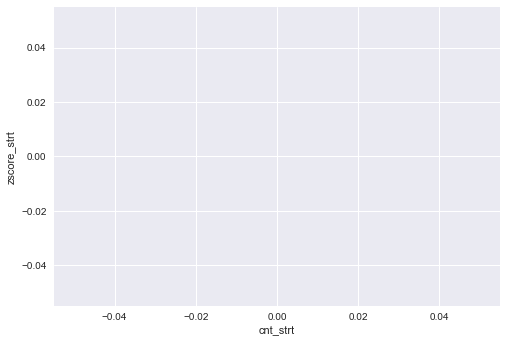

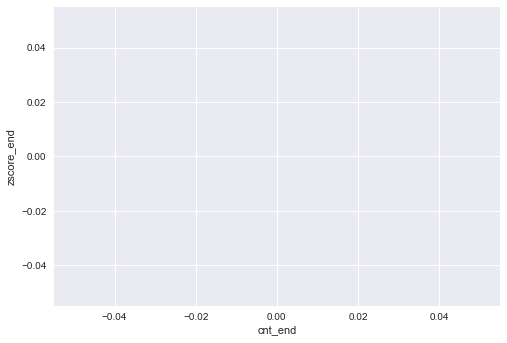

Site: 31227
Day: 3 Hour: 22 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-07 22:00:00       1.0      0.0  -1.014394  -1.00000     0.225875   
1  2011-04-14 22:00:00       0.0      0.0  -0.900000  -1.00000     0.714284   
2  2011-04-21 22:00:00       1.0      1.0  -1.014394  -1.00000     0.225875   
3  2011-04-28 22:00:00       1.0      0.0  -1.014394  -1.00000     0.225875   
4  2011-05-05 22:00:00       0.0      1.0  -0.900000  -1.00000     0.714284   
5  2011-05-12 22:00:00       0.0      0.0  -0.900000  -1.00000     0.714284   
6  2011-05-19 22:00:00       1.0      1.0  -1.014394  -1.00000     0.225875   
7  2011-05-26 22:00:00       2.0      2.0  -1.192500  -1.45625    -0.534554   
8  2011-06-02 22:00:00       2.0      0.0  -1.192500  -1.00000    -0.534554   
9  2011-06-09 22:00:00       2.0      0.0  -1.192500  -1.00000    -0.534554   
10 2011-06-16 22:00:00       0.0      3.0  -0.900000  -2.36000     0.714284   
11 2011-06-23 2

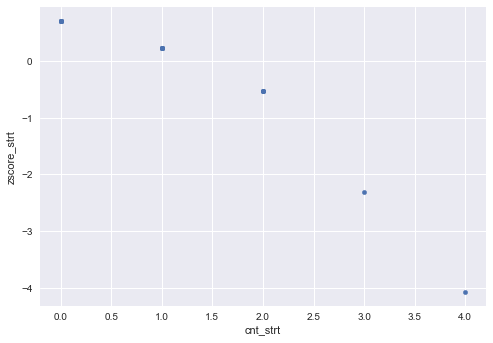

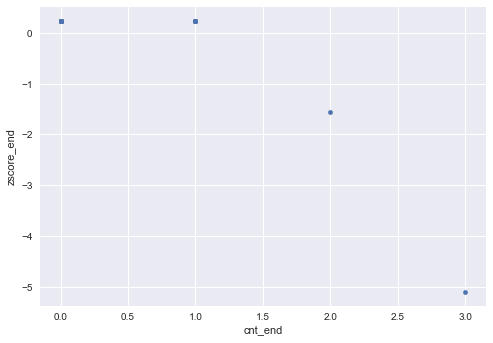

Site: 31215
Day: 2 Hour: 10 Week: 20
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-25 10:00:00       0.0      1.0  -0.990909 -1.021212     0.334681   
1  2011-06-01 10:00:00       1.0      0.0  -1.026667 -0.989706     0.243318   
2  2011-06-08 10:00:00       0.0      1.0  -0.990909 -1.021212     0.334681   
3  2011-06-15 10:00:00       0.0      5.0  -0.990909 -1.778648     0.334681   
4  2011-06-22 10:00:00       0.0      2.0  -0.990909 -0.961445     0.334681   
5  2011-06-29 10:00:00       1.0      2.0  -1.026667 -0.961445     0.243318   
6  2011-07-06 10:00:00       0.0      2.0  -0.990909 -0.961445     0.334681   
7  2011-07-13 10:00:00       0.0      0.0  -0.990909 -0.989706     0.334681   
8  2011-07-20 10:00:00       0.0      0.0  -0.990909 -0.989706     0.334681   
9  2011-07-27 10:00:00       1.0      2.0  -1.026667 -0.961445     0.243318   
10 2011-08-03 10:00:00       4.0      1.0  -3.045455 -1.021212    -4.914815   
11 2011-08-10 1

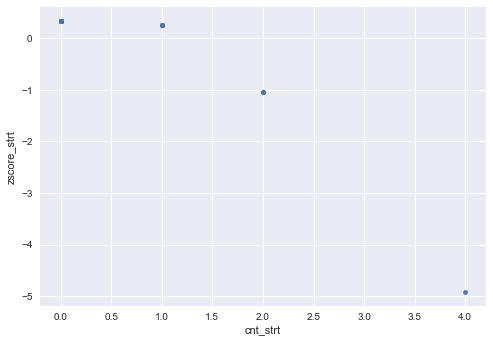

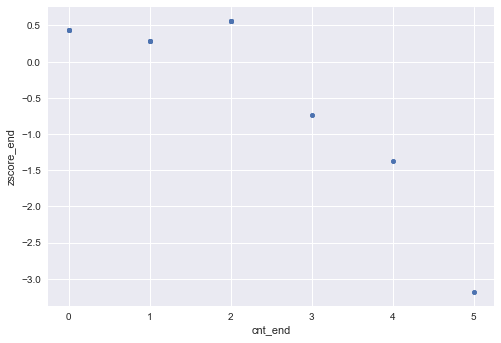

Site: 31621
Day: 2 Hour: 4 Week: 3
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-26 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-02 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-09 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-02-16 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-02-23 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-02 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-09 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-16 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-03-23 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-03-30 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-06 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-13 04:

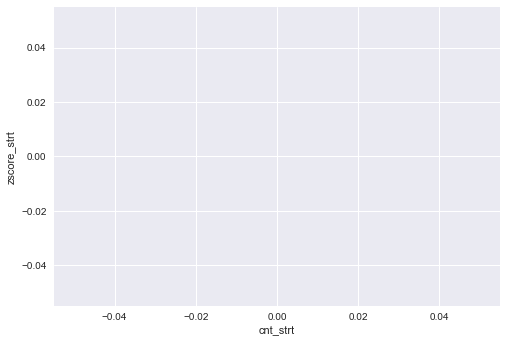

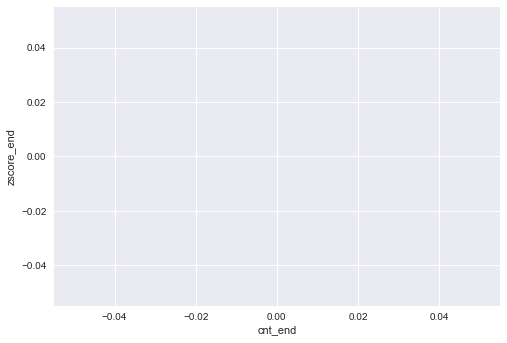

Site: 31208
Day: 2 Hour: 7 Week: 9
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-09 07:00:00       0.0      2.0  -0.977206 -1.030961     0.466498   
1  2011-03-16 07:00:00       0.0      2.0  -0.977206 -1.030961     0.466498   
2  2011-03-23 07:00:00       0.0      2.0  -0.977206 -1.030961     0.466498   
3  2011-03-30 07:00:00       0.0      2.0  -0.977206 -1.030961     0.466498   
4  2011-04-06 07:00:00       0.0      3.0  -0.977206 -1.001346     0.466498   
5  2011-04-13 07:00:00       0.0      1.0  -0.977206 -1.134615     0.466498   
6  2011-04-20 07:00:00       1.0      4.0  -0.991162 -0.978606     0.350217   
7  2011-04-27 07:00:00       1.0      2.0  -0.991162 -1.030961     0.350217   
8  2011-05-04 07:00:00       2.0      1.0  -1.001616 -1.134615     0.263110   
9  2011-05-11 07:00:00       1.0      4.0  -0.991162 -0.978606     0.350217   
10 2011-05-18 07:00:00       1.0      4.0  -0.991162 -0.978606     0.350217   
11 2011-05-25 07:

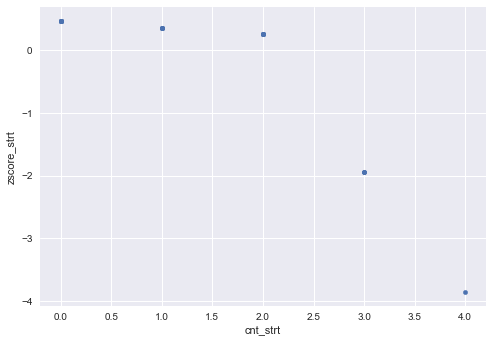

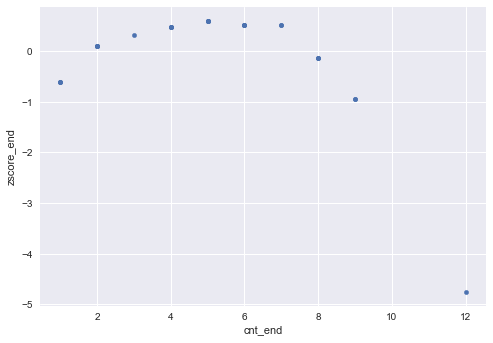

Site: 31702
Day: 1 Hour: 9 Week: 21
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-05-31 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
1  2011-06-07 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
2  2011-06-14 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
3  2011-06-21 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
4  2011-06-28 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
5  2011-07-05 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
6  2011-07-12 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
7  2011-07-19 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
8  2011-07-26 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
9  2011-08-02 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
10 2011-08-09 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
11 2011-08-16 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
12 2011-08-23 09:00:00       0.0      1.0       -1.0 -

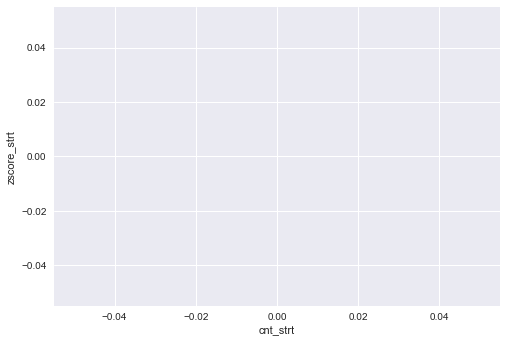

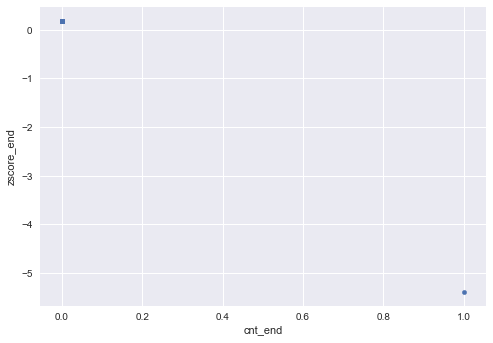

Site: 31238
Day: 1 Hour: 5 Week: 21
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-05-31 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-06-07 05:00:00       0.0      1.0 -1.000000e+00 -7.000000e+09   
2  2011-06-14 05:00:00       0.0      1.0 -1.000000e+00 -7.000000e+09   
3  2011-06-21 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-06-28 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-07-05 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-07-12 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-07-19 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-07-26 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-08-02 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-08-09 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-08-16 05:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-08-23 0

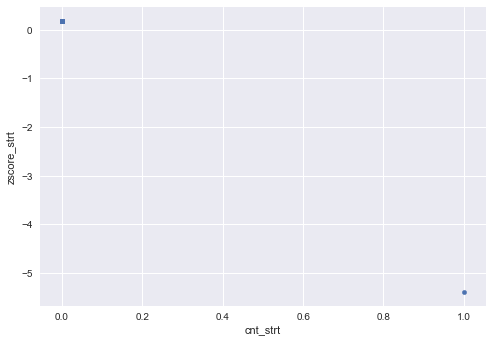

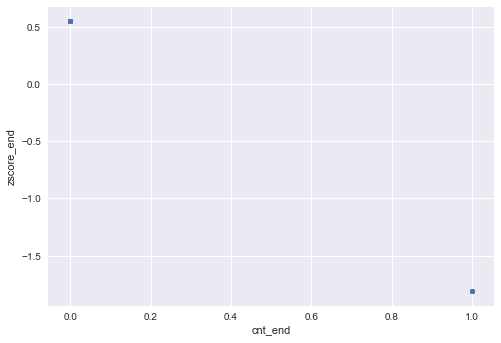

Site: 31100
Day: 6 Hour: 17 Week: 21
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-29 17:00:00       2.0      4.0  -0.952744 -1.293708     0.720073   
1  2011-06-05 17:00:00       6.0      3.0  -1.646283 -1.202609    -2.772541   
2  2011-06-12 17:00:00       5.0      5.0  -1.380600 -1.567005    -1.434581   
3  2011-06-19 17:00:00       1.0      0.0  -1.007546 -0.937618     0.444091   
4  2011-06-26 17:00:00       3.0      0.0  -1.001273 -0.937618     0.475685   
5  2011-07-03 17:00:00       3.0      5.0  -1.001273 -1.567005     0.475685   
6  2011-07-10 17:00:00       0.0      0.0  -1.007546 -0.937618     0.444091   
7  2011-07-17 17:00:00       4.0      3.0  -1.176228 -1.202609    -0.405380   
8  2011-07-24 17:00:00       6.0      0.0  -1.646283 -0.937618    -2.772541   
9  2011-07-31 17:00:00       5.0      0.0  -1.380600 -0.937618    -1.434581   
10 2011-08-07 17:00:00       1.0      1.0  -1.007546 -0.956686     0.444091   
11 2011-08-14 1

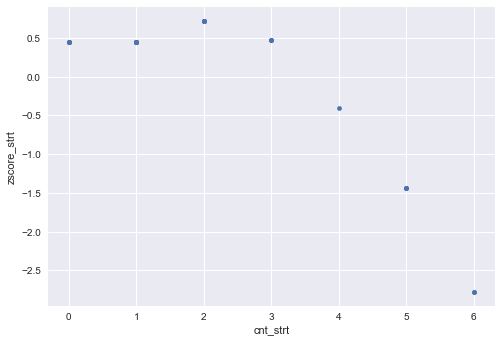

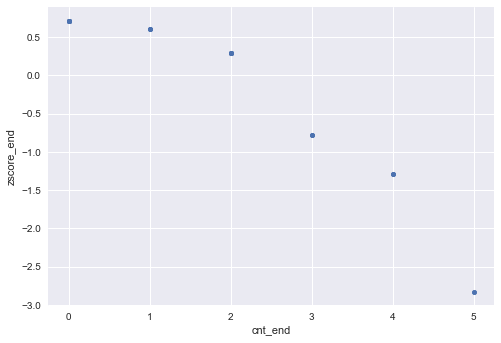

Site: 31226
Day: 3 Hour: 23 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-02-10 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
1  2011-02-17 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
2  2011-02-24 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
3  2011-03-03 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
4  2011-03-10 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
5  2011-03-17 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
6  2011-03-24 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
7  2011-03-31 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
8  2011-04-07 23:00:00       0.0      0.0  -0.997619 -1.000000e+00   
9  2011-04-14 23:00:00       0.0      3.0  -0.997619 -1.620000e+10   
10 2011-04-21 23:00:00       0.0      2.0  -0.997619 -1.170000e+10   
11 2011-04-28 23:00:00       1.0      0.0  -1.011371 -1.000000e+00   
12 2011-05-05 23:00:00       0.0      2.0  -0.997619 -

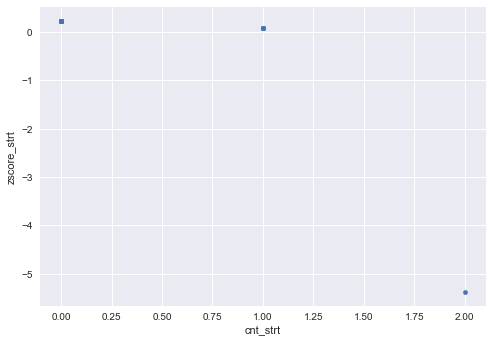

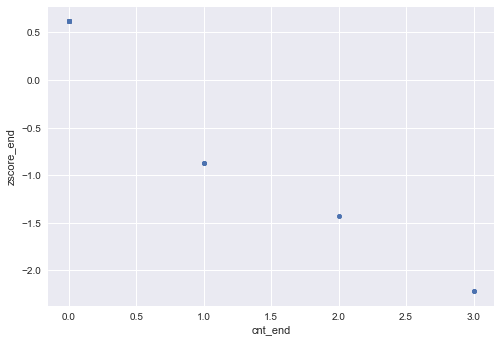

Site: 31112
Day: 5 Hour: 8 Week: 4
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-01-29 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
1  2011-02-05 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
2  2011-02-12 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
3  2011-02-19 08:00:00       1.0      1.0      -1.00 -8.400000e+09   
4  2011-02-26 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
5  2011-03-05 08:00:00       1.0      0.0      -1.00 -1.000000e+00   
6  2011-03-12 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
7  2011-03-19 08:00:00       1.0      0.0      -1.00 -1.000000e+00   
8  2011-03-26 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
9  2011-04-02 08:00:00       1.0      0.0      -1.00 -1.000000e+00   
10 2011-04-09 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
11 2011-04-16 08:00:00       0.0      0.0      -1.00 -1.000000e+00   
12 2011-04-23 08:00:00       0.0      0.0      -1.00 -1

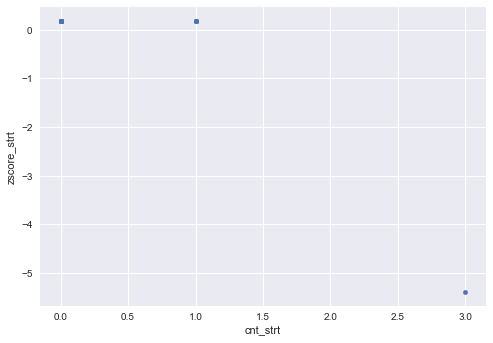

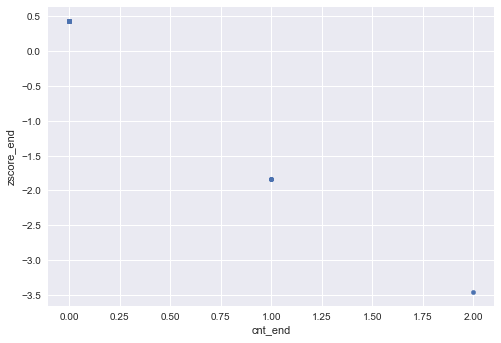

Site: 31202
Day: 4 Hour: 3 Week: 9
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-03-11 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-03-18 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-03-25 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-04-01 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-04-08 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-04-15 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-04-22 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-04-29 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-05-06 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-05-13 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-05-20 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-05-27 03:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-06-03 03

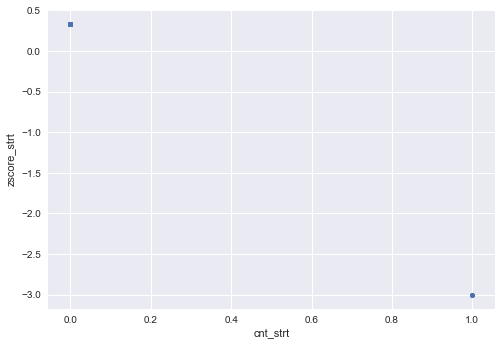

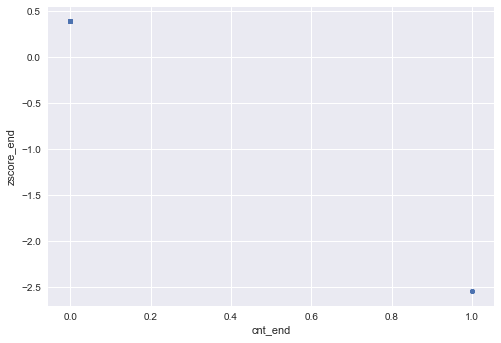

Site: 31015
Day: 2 Hour: 13 Week: 16
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-04-27 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
1  2011-05-04 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
2  2011-05-11 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
3  2011-05-18 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
4  2011-05-25 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
5  2011-06-01 13:00:00       0.0      2.0 -1.000000e+00 -1.542935   
6  2011-06-08 13:00:00       0.0      1.0 -1.000000e+00 -1.046071   
7  2011-06-15 13:00:00       0.0      2.0 -1.000000e+00 -1.542935   
8  2011-06-22 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
9  2011-06-29 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
10 2011-07-06 13:00:00       0.0      0.0 -1.000000e+00 -0.993478   
11 2011-07-13 13:00:00       0.0      1.0 -1.000000e+00 -1.046071   
12 2011-07-20 13:00:00       0.0      0.0 -1.000000e+00 -0.993478 

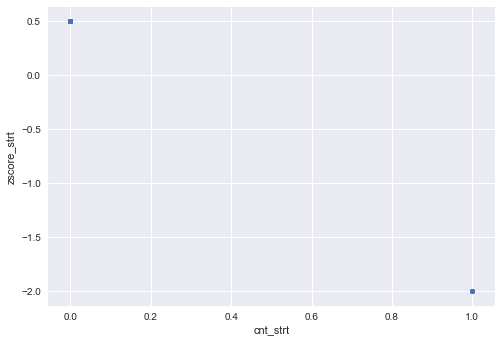

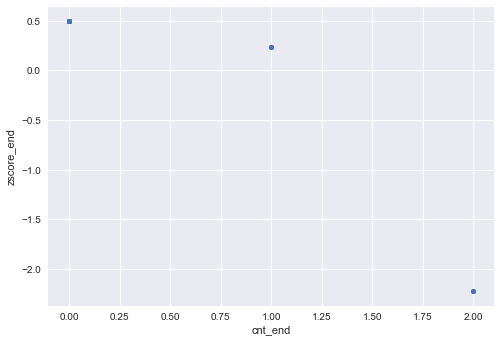

Site: 31500
Day: 3 Hour: 13 Week: 17
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-05-05 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-05-12 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-05-19 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-05-26 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-06-02 13:00:00       0.0      1.0 -1.000000e+00 -7.500000e+09   
5  2011-06-09 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-06-16 13:00:00       1.0      0.0 -9.500000e+09 -1.000000e+00   
7  2011-06-23 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-06-30 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-07-07 13:00:00       0.0      1.0 -1.000000e+00 -7.500000e+09   
10 2011-07-14 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-07-21 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-07-28 

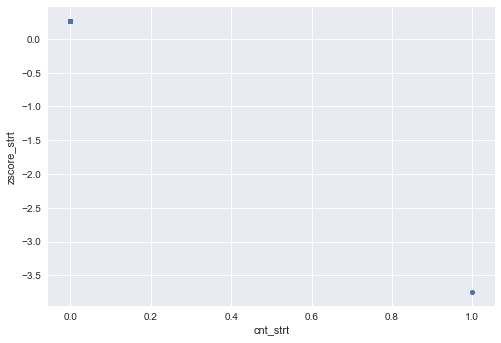

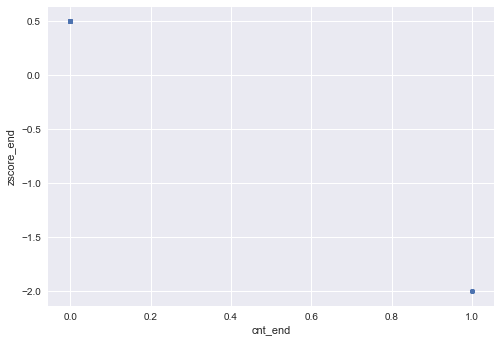

Site: 31102
Day: 2 Hour: 17 Week: 16
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-27 17:00:00       1.0      5.0  -0.999422 -1.010426     0.359254   
1  2011-05-04 17:00:00       1.0      5.0  -0.999422 -1.010426     0.359254   
2  2011-05-11 17:00:00       0.0      4.0  -1.133963 -0.945558    -0.657827   
3  2011-05-18 17:00:00       1.0      6.0  -0.999422 -1.097346     0.359254   
4  2011-05-25 17:00:00       3.0      7.0  -0.968915 -1.271187     0.589878   
5  2011-06-01 17:00:00       4.0      5.0  -1.268241 -1.010426    -1.672918   
6  2011-06-08 17:00:00       2.0      4.0  -0.945749 -0.945558     0.765000   
7  2011-06-15 17:00:00       1.0      7.0  -0.999422 -1.271187     0.359254   
8  2011-06-22 17:00:00       2.0      4.0  -0.945749 -0.945558     0.765000   
9  2011-06-29 17:00:00       5.0      7.0  -1.531889 -1.271187    -3.665998   
10 2011-07-06 17:00:00       1.0      4.0  -0.999422 -0.945558     0.359254   
11 2011-07-13 1

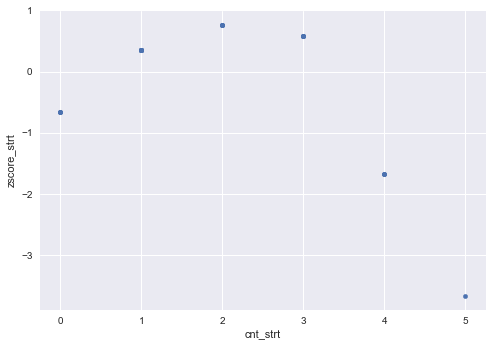

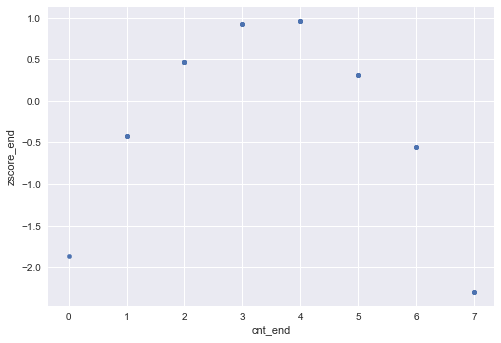

Site: 31220
Day: 3 Hour: 4 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-07 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-14 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-21 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-28 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-05 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-12 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-19 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-26 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-02 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-09 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-16 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-06-23 04

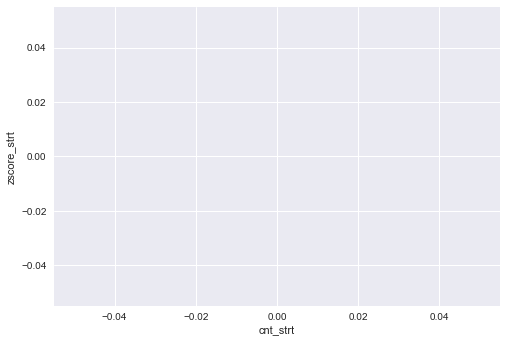

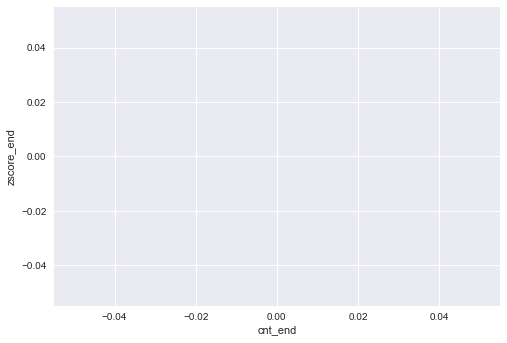

Site: 31626
Day: 6 Hour: 4 Week: 7
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-20 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-27 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-03-06 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-03-13 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-20 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-27 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-04-03 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-04-10 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-17 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-24 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-05-01 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-05-08 04:

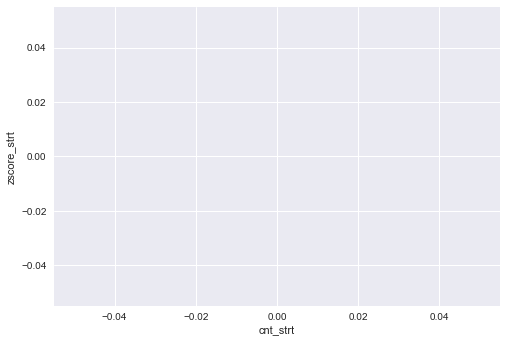

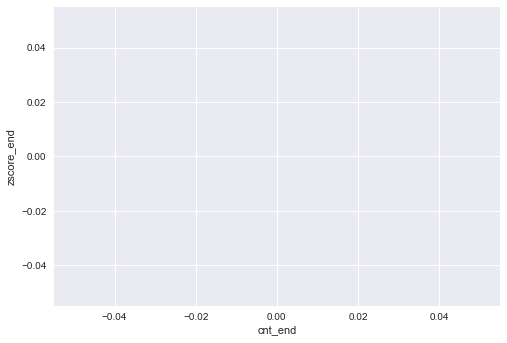

Site: 31307
Day: 6 Hour: 23 Week: 1
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-09 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-01-16 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-01-23 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-01-30 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-02-06 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-02-13 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-02-20 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-02-27 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-03-06 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-03-13 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-03-20 23:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-03-27 23

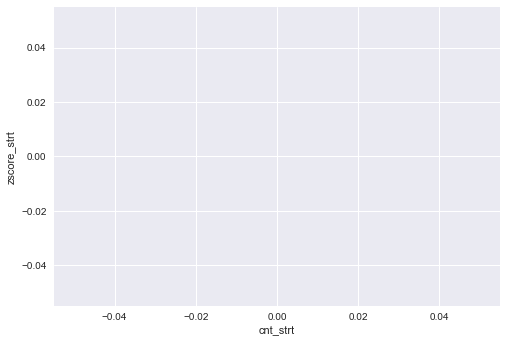

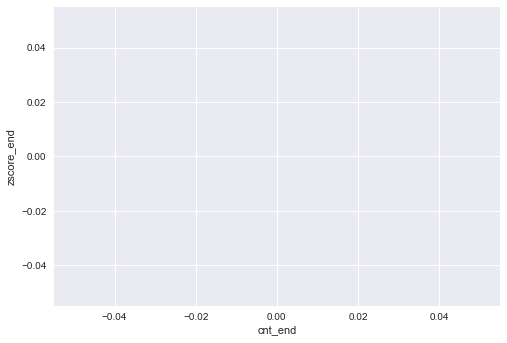

Site: 31621
Day: 5 Hour: 19 Week: 6
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-02-12 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-02-19 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-02-26 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-03-05 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-03-12 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-03-19 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-03-26 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-04-02 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-04-09 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-04-16 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-04-23 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-30 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-05-07 1

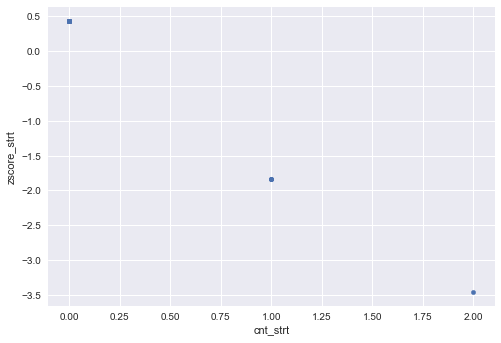

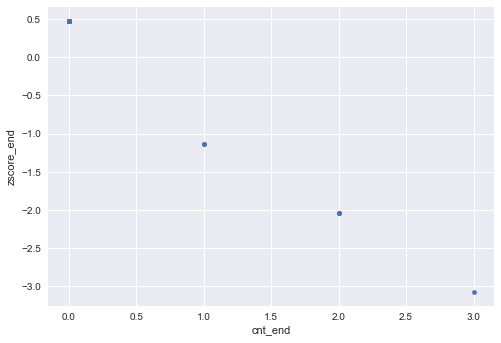

Site: 31100
Day: 2 Hour: 0 Week: 15
     datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  zscore_strt  \
0  2011-04-20       1.0      0.0 -8.500000e+09 -1.000000e+00    -2.549510   
1  2011-04-27       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
2  2011-05-04       0.0      2.0 -1.000000e+00 -1.572500e+10     0.392232   
3  2011-05-11       1.0      0.0 -8.500000e+09 -1.000000e+00    -2.549510   
4  2011-05-18       1.0      0.0 -8.500000e+09 -1.000000e+00    -2.549510   
5  2011-05-25       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
6  2011-06-01       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
7  2011-06-08       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
8  2011-06-15       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
9  2011-06-22       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
10 2011-06-29       0.0      0.0 -1.000000e+00 -1.000000e+00     0.392232   
11 2011-07-06       0.0      1.0 -1.0000

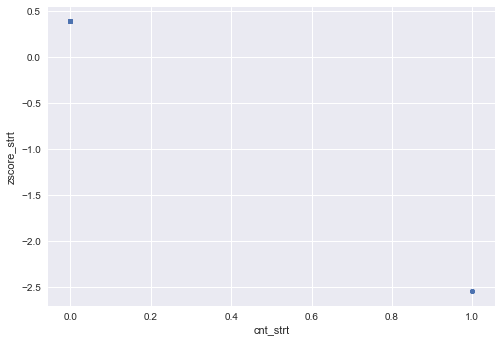

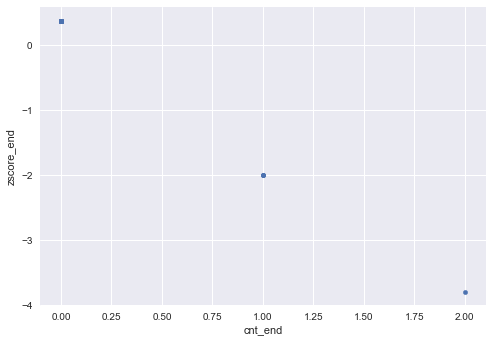

Site: 31016
Day: 4 Hour: 19 Week: 8
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-03-04 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-03-11 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-03-18 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-03-25 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-04-01 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-04-08 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-04-15 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-04-22 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-04-29 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-05-06 19:00:00       1.0      3.0 -7.875000e+09 -1.890000e+10   
10 2011-05-13 19:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-05-20 19:00:00       2.0      0.0 -1.137500e+10 -1.000000e+00   
12 2011-05-27 1

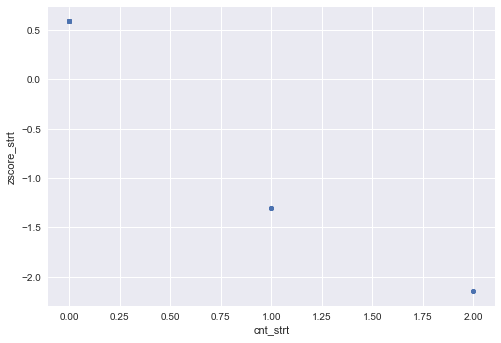

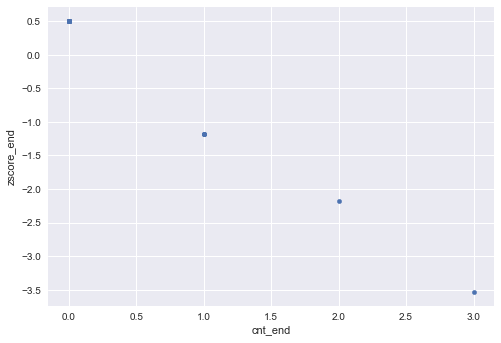

Site: 31221
Day: 3 Hour: 5 Week: 7
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-24 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
1  2011-03-03 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
2  2011-03-10 05:00:00       0.0      0.0       -1.0 -0.992857          NaN   
3  2011-03-17 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
4  2011-03-24 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
5  2011-03-31 05:00:00       0.0      0.0       -1.0 -0.992857          NaN   
6  2011-04-07 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
7  2011-04-14 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
8  2011-04-21 05:00:00       0.0      1.0       -1.0 -1.010000          NaN   
9  2011-04-28 05:00:00       0.0      0.0       -1.0 -0.992857          NaN   
10 2011-05-05 05:00:00       0.0      2.0       -1.0 -1.439286          NaN   
11 2011-05-12 05:

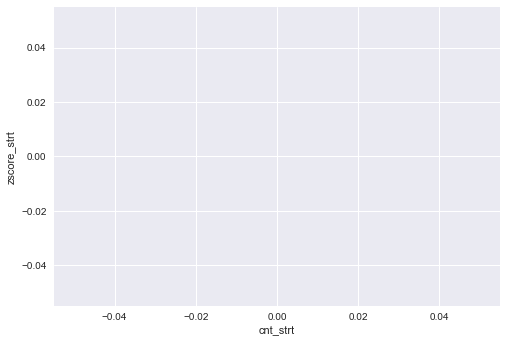

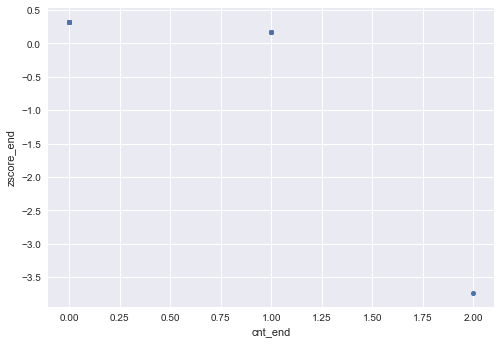

Site: 31217
Day: 5 Hour: 4 Week: 21
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-05-28 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-06-04 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-06-11 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-06-18 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-06-25 04:00:00       2.0      2.0 -2.000000e+10 -1.852500e+10   
5  2011-07-02 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-07-09 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-07-16 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-07-23 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-07-30 04:00:00       0.0      1.0 -1.000000e+00 -9.975000e+09   
10 2011-08-06 04:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-08-13 04:00:00       0.0      4.0 -1.000000e+00 -3.465000e+10   
12 2011-08-20 0

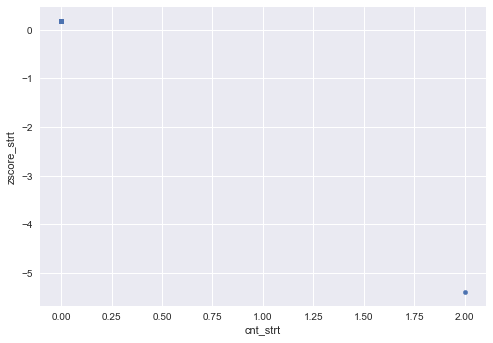

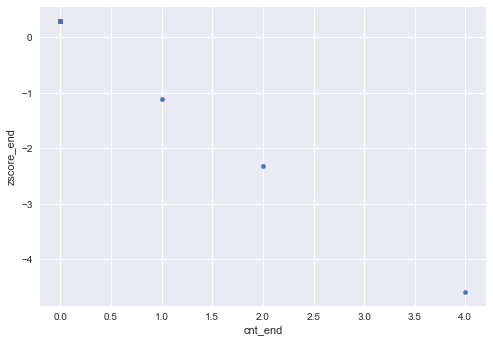

Site: 31614
Day: 3 Hour: 5 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-07 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-14 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-21 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-28 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-05 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-12 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-19 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-26 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-02 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-09 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-16 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-06-23 05

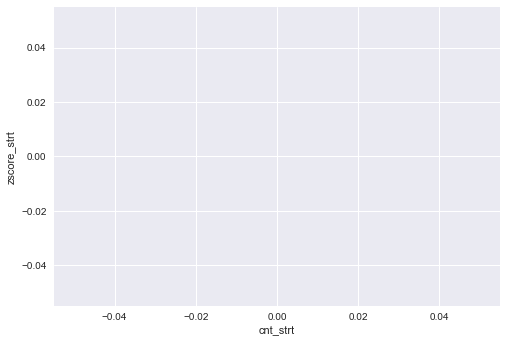

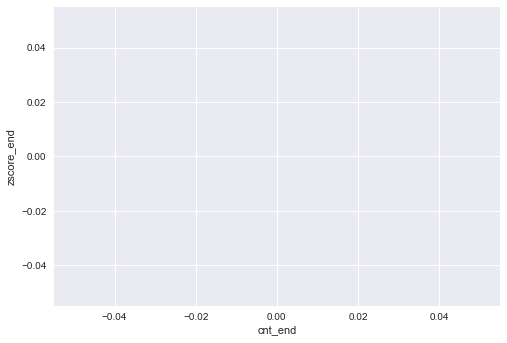

Site: 31220
Day: 6 Hour: 20 Week: 10
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-13 20:00:00       1.0      0.0  -1.016111 -0.987375     0.400464   
1  2011-03-20 20:00:00       0.0      0.0  -0.972727 -0.987375     0.515567   
2  2011-03-27 20:00:00       0.0      0.0  -0.972727 -0.987375     0.515567   
3  2011-04-03 20:00:00       2.0      2.0  -1.447047 -1.007287    -0.742868   
4  2011-04-10 20:00:00       0.0      2.0  -0.972727 -1.007287     0.515567   
5  2011-04-17 20:00:00       3.0      3.0  -1.987647 -1.293040    -2.177153   
6  2011-04-24 20:00:00       0.0      2.0  -0.972727 -1.007287     0.515567   
7  2011-05-01 20:00:00       0.0      0.0  -0.972727 -0.987375     0.515567   
8  2011-05-08 20:00:00       1.0      1.0  -1.016111 -0.997019     0.400464   
9  2011-05-15 20:00:00       1.0      0.0  -1.016111 -0.987375     0.400464   
10 2011-05-22 20:00:00       0.0      0.0  -0.972727 -0.987375     0.515567   
11 2011-05-29 2

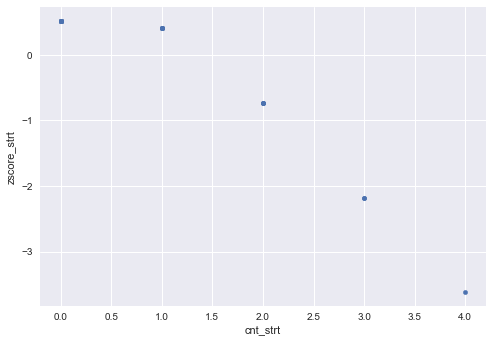

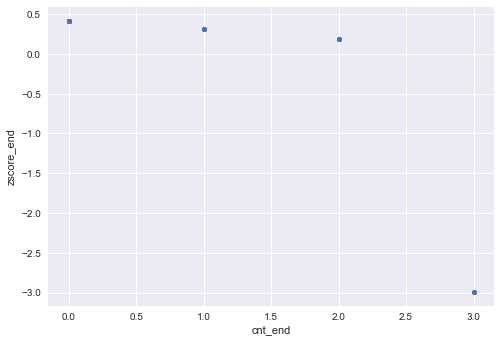

Site: 31303
Day: 4 Hour: 7 Week: 11
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-25 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
1  2011-04-01 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
2  2011-04-08 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
3  2011-04-15 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
4  2011-04-22 07:00:00       2.0      1.0  -1.568424 -1.023750    -1.808862   
5  2011-04-29 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
6  2011-05-06 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
7  2011-05-13 07:00:00       0.0      1.0  -0.997619 -1.023750     0.258059   
8  2011-05-20 07:00:00       3.0      0.0  -2.451201 -0.995455    -5.005450   
9  2011-05-27 07:00:00       0.0      0.0  -0.997619 -0.995455     0.258059   
10 2011-06-03 07:00:00       0.0      1.0  -0.997619 -1.023750     0.258059   
11 2011-06-10 07

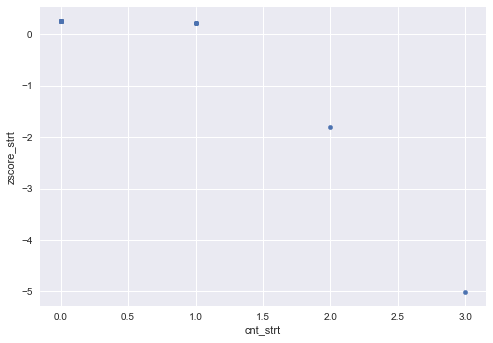

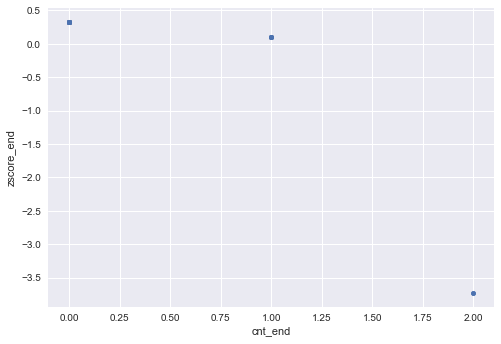

Site: 31206
Day: 1 Hour: 14 Week: 21
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-31 14:00:00       1.0      3.0  -1.008750 -2.157314     0.246945   
1  2011-06-07 14:00:00       0.0      1.0  -0.959091 -1.011667     0.276694   
2  2011-06-14 14:00:00       0.0      1.0  -0.959091 -1.011667     0.276694   
3  2011-06-21 14:00:00       2.0      1.0  -1.324348 -1.011667     0.057883   
4  2011-06-28 14:00:00       0.0      0.0  -0.959091 -0.977273     0.276694   
5  2011-07-05 14:00:00       1.0      0.0  -1.008750 -0.977273     0.246945   
6  2011-07-12 14:00:00       1.0      1.0  -1.008750 -1.011667     0.246945   
7  2011-07-19 14:00:00       1.0      1.0  -1.008750 -1.011667     0.246945   
8  2011-07-26 14:00:00       1.0      0.0  -1.008750 -0.977273     0.246945   
9  2011-08-02 14:00:00       0.0      1.0  -0.959091 -1.011667     0.276694   
10 2011-08-09 14:00:00       0.0      0.0  -0.959091 -0.977273     0.276694   
11 2011-08-16 1

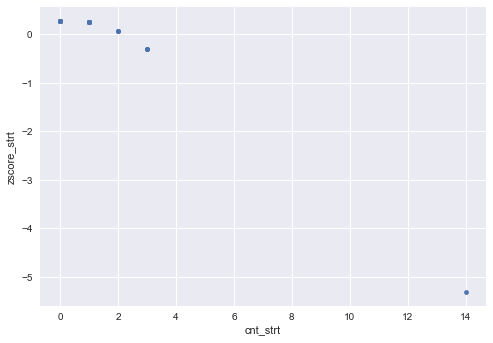

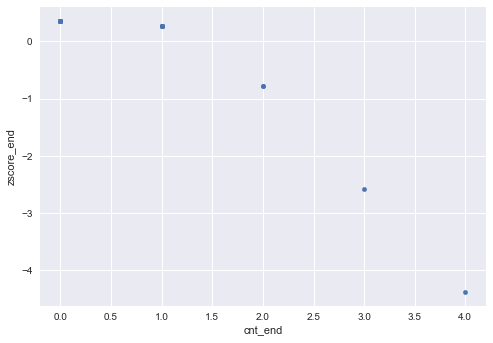

Site: 31000
Day: 0 Hour: 3 Week: 20
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-05-23 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
1  2011-05-30 03:00:00       0.0      1.0       -1.0 -9.500000e+09   
2  2011-06-06 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
3  2011-06-13 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
4  2011-06-20 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
5  2011-06-27 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
6  2011-07-04 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
7  2011-07-11 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
8  2011-07-18 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
9  2011-07-25 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
10 2011-08-01 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
11 2011-08-08 03:00:00       0.0      0.0       -1.0 -1.000000e+00   
12 2011-08-15 03:00:00       0.0      0.0       -1.0 -

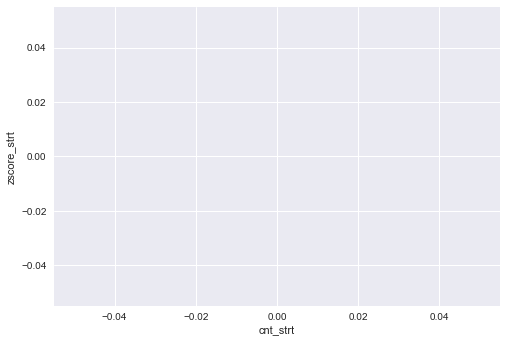

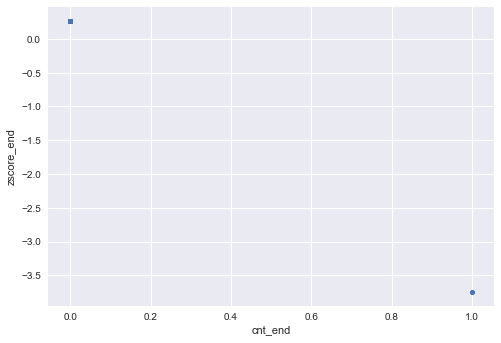

Site: 31225
Day: 3 Hour: 5 Week: 12
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-31 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-07 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-14 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-21 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-04-28 05:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-05 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
6  2011-05-12 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
7  2011-05-19 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
8  2011-05-26 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
9  2011-06-02 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
10 2011-06-09 05:00:00       0.0      1.0       -1.0      -1.0          NaN   
11 2011-06-16 05

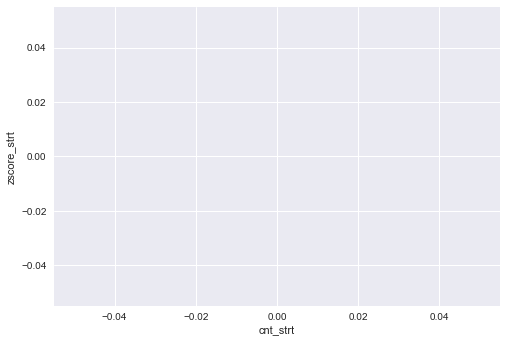

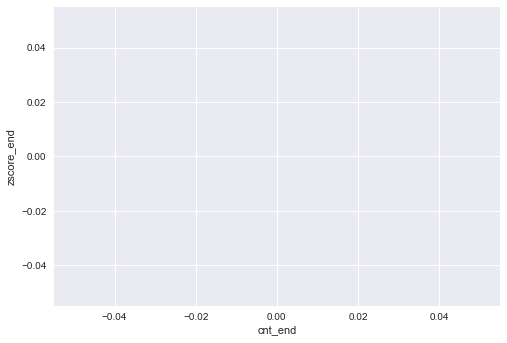

Site: 31703
Day: 6 Hour: 12 Week: 4
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-01-30 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-02-06 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-02-13 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-02-20 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-02-27 12:00:00       1.0      1.0 -9.500000e+09 -1.000000e+10   
5  2011-03-06 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-03-13 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-20 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-03-27 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-04-03 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-04-10 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-17 12:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-04-24 1

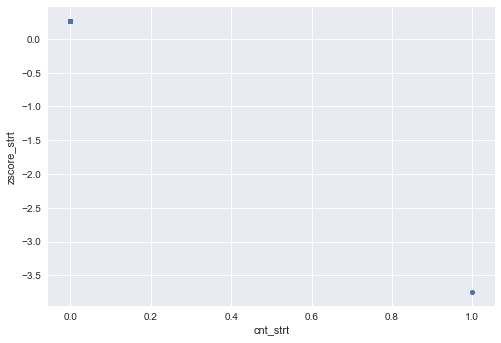

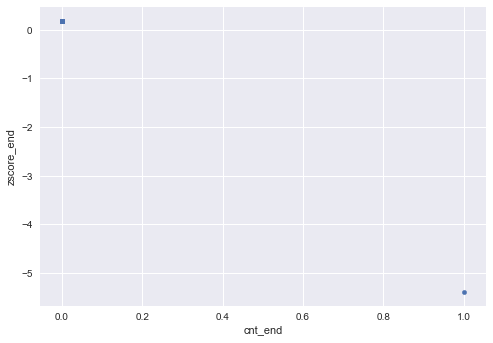

Site: 31003
Day: 4 Hour: 13 Week: 10
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-18 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
1  2011-03-25 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
2  2011-04-01 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
3  2011-04-08 13:00:00       0.0      1.0  -0.972727 -0.997019     0.355287   
4  2011-04-15 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
5  2011-04-22 13:00:00       1.0      0.0  -1.018750 -0.979266     0.308063   
6  2011-04-29 13:00:00       2.0      2.0  -1.426545 -1.010199    -0.110382   
7  2011-05-06 13:00:00       1.0      2.0  -1.018750 -1.010199     0.308063   
8  2011-05-13 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
9  2011-05-20 13:00:00       0.0      0.0  -0.972727 -0.979266     0.355287   
10 2011-05-27 13:00:00       5.0      4.0  -3.569151 -1.549457    -2.308940   
11 2011-06-03 1

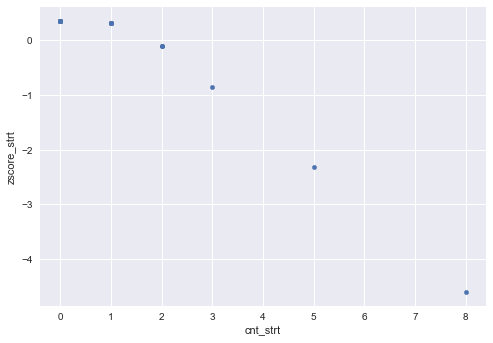

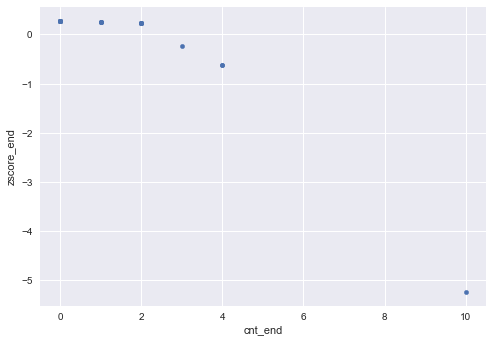

Site: 31208
Day: 0 Hour: 13 Week: 3
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-24 13:00:00       0.0      0.0  -1.000000 -0.986458     0.443142   
1  2011-01-31 13:00:00       0.0      0.0  -1.000000 -0.986458     0.443142   
2  2011-02-07 13:00:00       0.0      0.0  -1.000000 -0.986458     0.443142   
3  2011-02-14 13:00:00       1.0      1.0  -1.000000 -1.008511     0.443142   
4  2011-02-21 13:00:00       0.0      1.0  -1.000000 -1.008511     0.443142   
5  2011-02-28 13:00:00       1.0      0.0  -1.000000 -0.986458     0.443142   
6  2011-03-07 13:00:00       0.0      0.0  -1.000000 -0.986458     0.443142   
7  2011-03-14 13:00:00       0.0      2.0  -1.000000 -0.971448     0.443142   
8  2011-03-21 13:00:00       1.0      1.0  -1.000000 -1.008511     0.443142   
9  2011-03-28 13:00:00       0.0      1.0  -1.000000 -1.008511     0.443142   
10 2011-04-04 13:00:00       1.0      1.0  -1.000000 -1.008511     0.443142   
11 2011-04-11 13

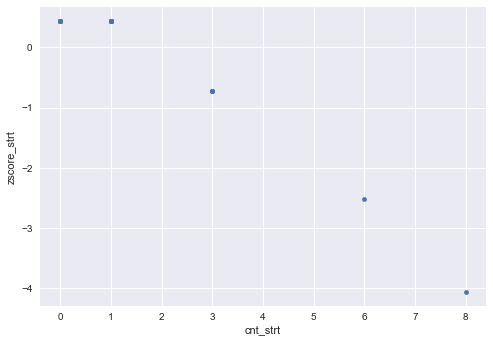

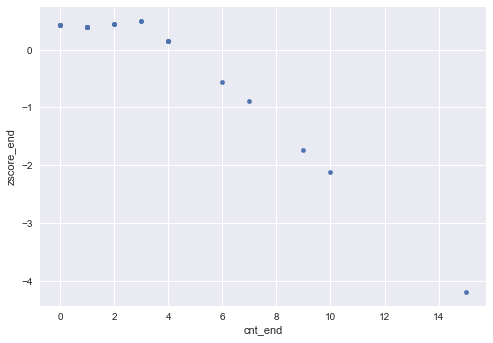

Site: 31703
Day: 3 Hour: 3 Week: 15
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-21 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-28 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-05-05 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-12 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-19 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-26 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-06-02 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-09 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-16 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-23 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-30 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-07 03

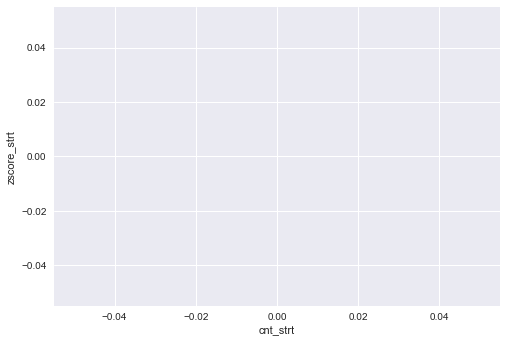

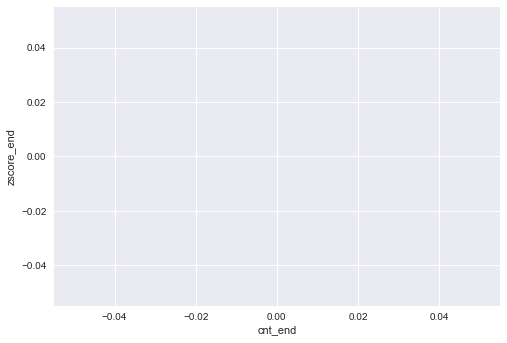

Site: 31223
Day: 3 Hour: 19 Week: 14
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-14 19:00:00       3.0      1.0  -1.005048 -1.537914     0.391920   
1  2011-04-21 19:00:00       5.0      4.0  -0.965036 -0.976176     0.479523   
2  2011-04-28 19:00:00       5.0      5.0  -0.965036 -0.962214     0.479523   
3  2011-05-05 19:00:00       4.0      8.0  -0.975000 -1.431763     0.457708   
4  2011-05-12 19:00:00       4.0      4.0  -0.975000 -0.976176     0.457708   
5  2011-05-19 19:00:00       4.0      5.0  -0.975000 -0.962214     0.457708   
6  2011-05-26 19:00:00       2.0      6.0  -1.314563 -1.036626    -0.285735   
7  2011-06-02 19:00:00       5.0      6.0  -0.965036 -1.036626     0.479523   
8  2011-06-09 19:00:00       3.0      2.0  -1.005048 -1.234342     0.391920   
9  2011-06-16 19:00:00       6.0      5.0  -1.339343 -0.962214    -0.339988   
10 2011-06-23 19:00:00      10.0      6.0  -3.227194 -1.036626    -4.473262   
11 2011-06-30 1

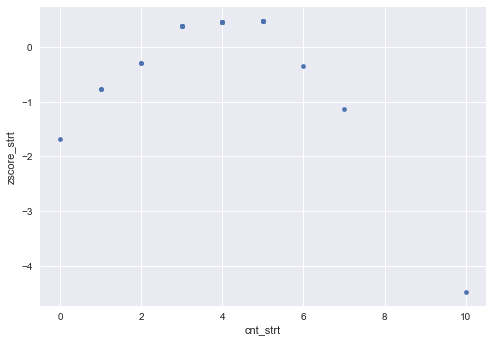

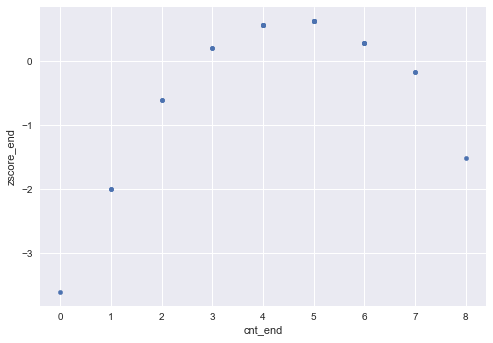

Site: 31302
Day: 3 Hour: 16 Week: 0
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-01-06 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
1  2011-01-13 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
2  2011-01-20 16:00:00       0.0      1.0 -1.000000e+00 -1.025455   
3  2011-01-27 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
4  2011-02-03 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
5  2011-02-10 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
6  2011-02-17 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
7  2011-02-24 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
8  2011-03-03 16:00:00       0.0      1.0 -1.000000e+00 -1.025455   
9  2011-03-10 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
10 2011-03-17 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
11 2011-03-24 16:00:00       0.0      0.0 -1.000000e+00 -0.941667   
12 2011-03-31 16:00:00       0.0      0.0 -1.000000e+00 -0.941667  

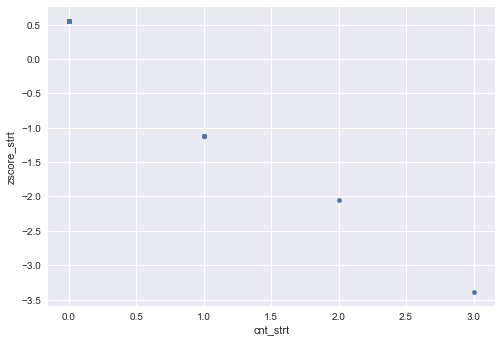

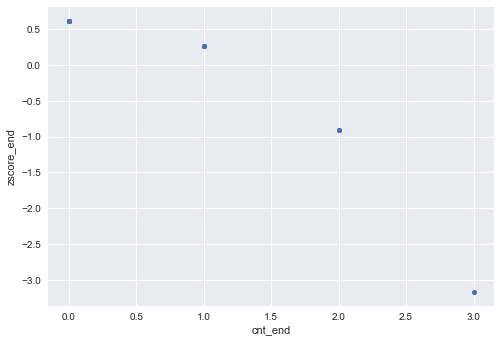

Site: 31209
Day: 1 Hour: 13 Week: 9
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-03-08 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-03-15 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-03-22 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-03-29 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-04-05 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-04-12 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-04-19 13:00:00       1.0      1.0 -9.000000e+09 -8.925000e+09   
7  2011-04-26 13:00:00       0.0      1.0 -1.000000e+00 -8.925000e+09   
8  2011-05-03 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-05-10 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-05-17 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-05-24 13:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-05-31 1

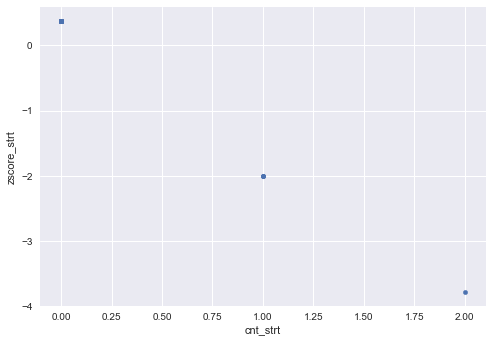

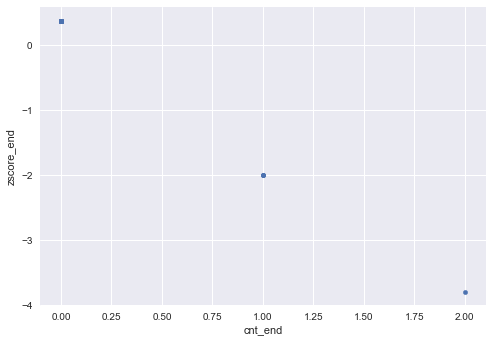

Site: 31013
Day: 0 Hour: 18 Week: 4
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-01-31 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
1  2011-02-07 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
2  2011-02-14 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
3  2011-02-21 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
4  2011-02-28 18:00:00       0.0      1.0 -1.000000e+00 -1.053571   
5  2011-03-07 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
6  2011-03-14 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
7  2011-03-21 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
8  2011-03-28 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
9  2011-04-04 18:00:00       1.0      1.0 -8.400000e+09 -1.053571   
10 2011-04-11 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
11 2011-04-18 18:00:00       0.0      0.0 -1.000000e+00 -0.940000   
12 2011-04-25 18:00:00       0.0      0.0 -1.000000e+00 -0.940000  

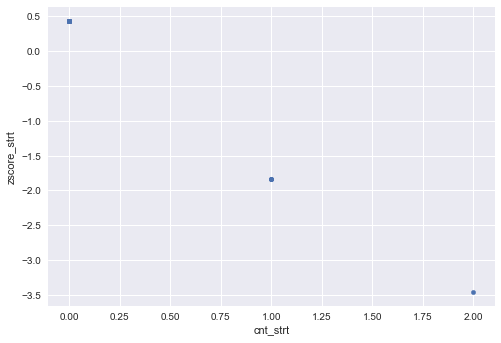

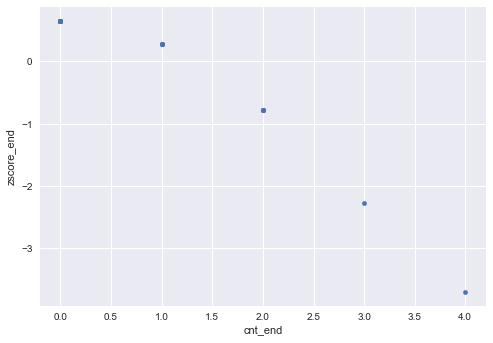

Site: 31703
Day: 0 Hour: 9 Week: 2
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-01-17 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
1  2011-01-24 09:00:00       0.0      1.0       -1.0 -1.000000e+10   
2  2011-01-31 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
3  2011-02-07 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
4  2011-02-14 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
5  2011-02-21 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
6  2011-02-28 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
7  2011-03-07 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
8  2011-03-14 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
9  2011-03-21 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
10 2011-03-28 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
11 2011-04-04 09:00:00       0.0      0.0       -1.0 -1.000000e+00   
12 2011-04-11 09:00:00       0.0      0.0       -1.0 -1

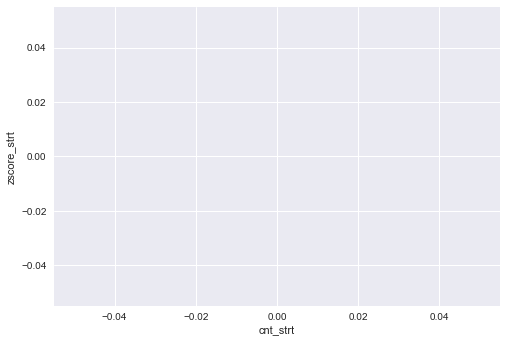

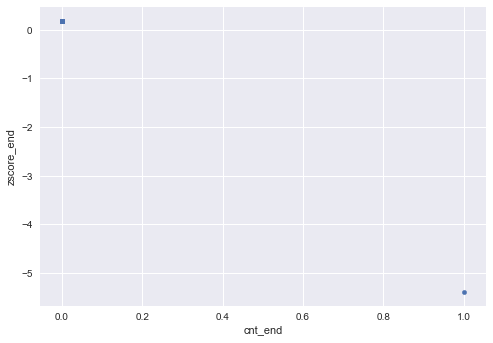

Site: 31701
Day: 0 Hour: 10 Week: 18
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-09 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-05-16 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-05-23 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-30 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-06-06 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-06-13 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-06-20 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-27 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-07-04 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-07-11 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-07-18 10:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-25 1

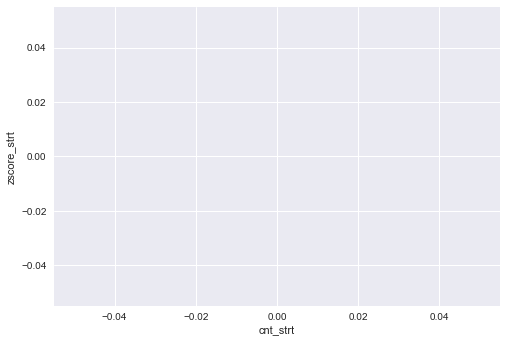

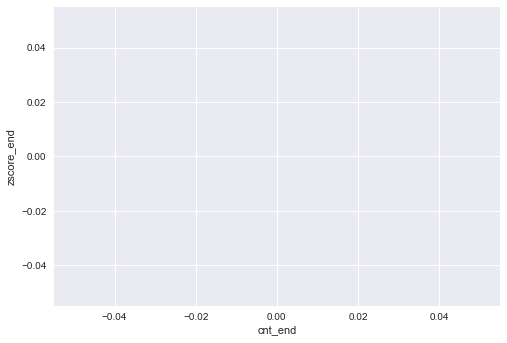

Site: 31266
Day: 2 Hour: 8 Week: 20
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-25 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-06-01 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-06-08 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-06-15 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-06-22 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-06-29 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-07-06 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-07-13 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-07-20 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-07-27 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-08-03 08:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-08-10 08

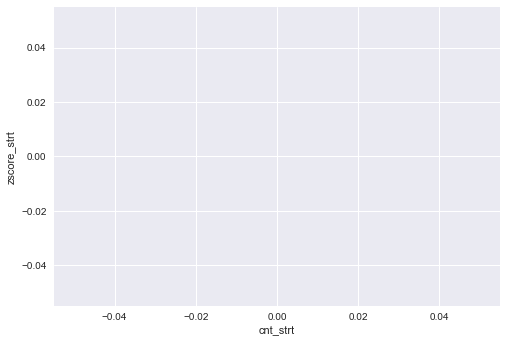

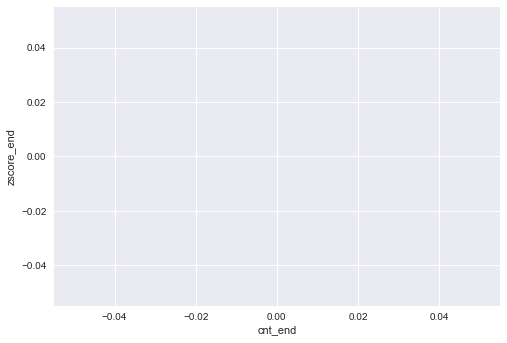

Site: 31400
Day: 3 Hour: 10 Week: 19
              datetime  cnt_strt  cnt_end  nlof_strt      nlof_end  \
0  2011-05-19 10:00:00       2.0      0.0  -1.399420 -1.000000e+00   
1  2011-05-26 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
2  2011-06-02 10:00:00       2.0      0.0  -1.399420 -1.000000e+00   
3  2011-06-09 10:00:00       0.0      0.0  -0.973913 -1.000000e+00   
4  2011-06-16 10:00:00       0.0      0.0  -0.973913 -1.000000e+00   
5  2011-06-23 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
6  2011-06-30 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
7  2011-07-07 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
8  2011-07-14 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
9  2011-07-21 10:00:00       0.0      1.0  -0.973913 -7.875000e+09   
10 2011-07-28 10:00:00       0.0      1.0  -0.973913 -7.875000e+09   
11 2011-08-04 10:00:00       1.0      0.0  -1.025312 -1.000000e+00   
12 2011-08-11 10:00:00       1.0      0.0  -1.025312 

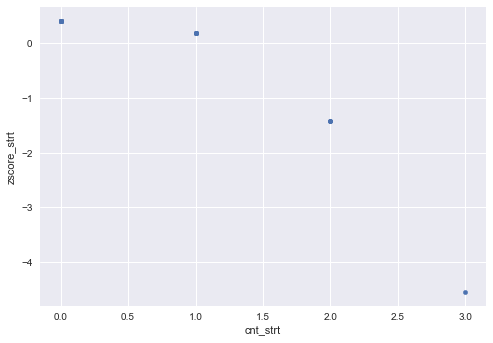

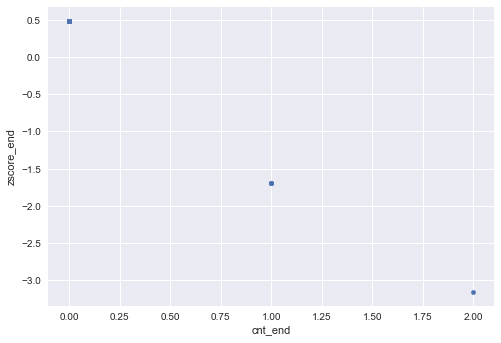

Site: 31301
Day: 6 Hour: 14 Week: 11
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-20 14:00:00       2.0      0.0  -1.478247 -0.986364    -1.139263   
1  2011-03-27 14:00:00       0.0      0.0  -0.981818 -0.986364     0.491475   
2  2011-04-03 14:00:00       1.0      2.0  -1.022857 -1.524242     0.356665   
3  2011-04-10 14:00:00       0.0      0.0  -0.981818 -0.986364     0.491475   
4  2011-04-17 14:00:00       3.0      0.0  -2.089545 -0.986364    -3.147343   
5  2011-04-24 14:00:00       0.0      2.0  -0.981818 -1.524242     0.491475   
6  2011-05-01 14:00:00       0.0      0.0  -0.981818 -0.986364     0.491475   
7  2011-05-08 14:00:00       1.0      1.0  -1.022857 -1.024706     0.356665   
8  2011-05-15 14:00:00       0.0      0.0  -0.981818 -0.986364     0.491475   
9  2011-05-22 14:00:00       0.0      1.0  -0.981818 -1.024706     0.491475   
10 2011-05-29 14:00:00       0.0      0.0  -0.981818 -0.986364     0.491475   
11 2011-06-05 1

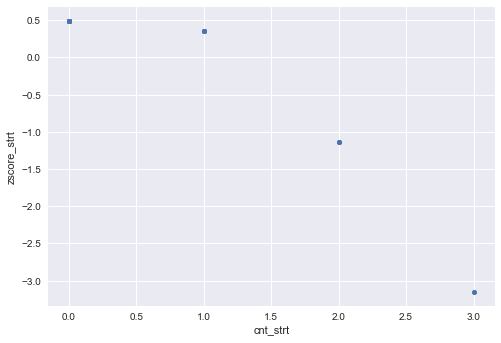

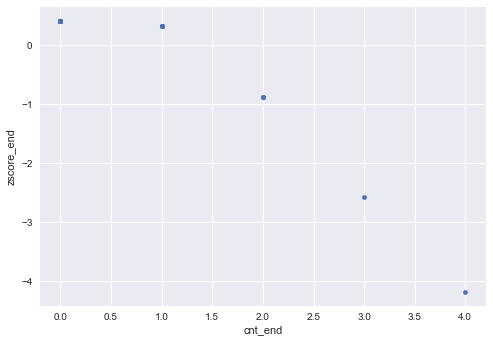

Site: 31106
Day: 4 Hour: 9 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-08 09:00:00       5.0      3.0  -0.962003 -0.995805     0.786591   
1  2011-04-15 09:00:00       6.0      3.0  -1.009644 -0.995805     0.340328   
2  2011-04-22 09:00:00       7.0      3.0  -1.146373 -0.995805    -0.940431   
3  2011-04-29 09:00:00       2.0      2.0  -1.007899 -0.950747     0.356677   
4  2011-05-06 09:00:00       3.0      2.0  -0.981461 -0.950747     0.604326   
5  2011-05-13 09:00:00       3.0      1.0  -0.981461 -0.982532     0.604326   
6  2011-05-20 09:00:00       2.0      0.0  -1.007899 -1.233688     0.356677   
7  2011-05-27 09:00:00       1.0      3.0  -1.129297 -0.995805    -0.780482   
8  2011-06-03 09:00:00       4.0      1.0  -0.944811 -0.982532     0.947629   
9  2011-06-10 09:00:00       4.0      4.0  -0.944811 -1.223500     0.947629   
10 2011-06-17 09:00:00       8.0      1.0  -1.283101 -0.982532    -2.221190   
11 2011-06-24 09

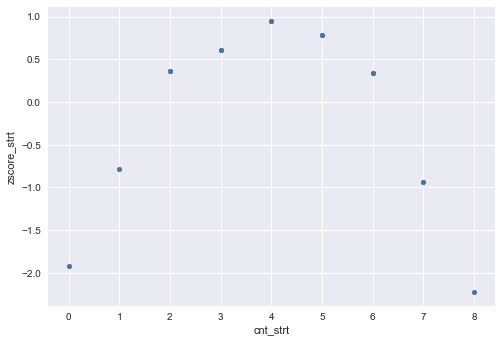

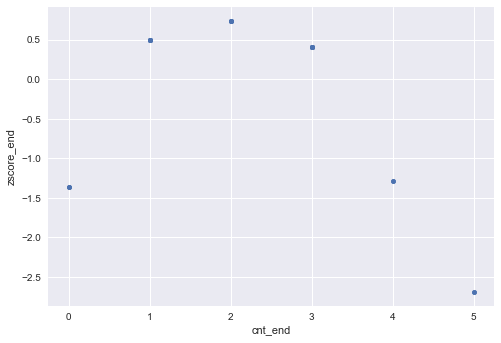

Site: 31116
Day: 0 Hour: 11 Week: 15
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-18 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-04-25 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-05-02 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-09 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-05-16 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-05-23 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-30 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-06 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-06-13 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-06-20 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-06-27 11:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-04 1

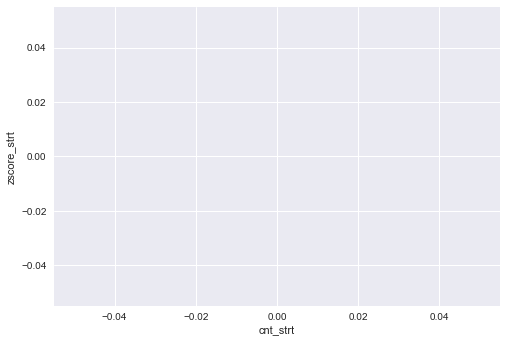

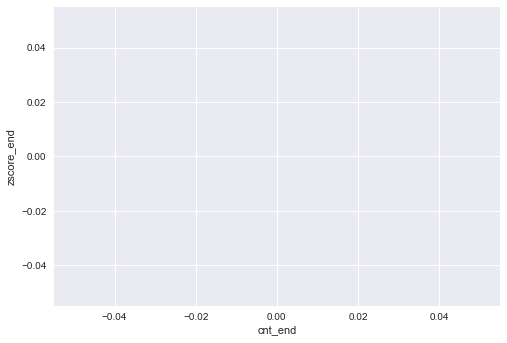

Site: 31224
Day: 2 Hour: 18 Week: 11
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-23 18:00:00       2.0      2.0  -0.992711 -0.985512     0.476636   
1  2011-03-30 18:00:00       4.0      1.0  -0.960189 -1.030534     0.748406   
2  2011-04-06 18:00:00       9.0      4.0  -1.136316 -0.947210    -0.723407   
3  2011-04-13 18:00:00       7.0      7.0  -1.013037 -1.602537     0.306780   
4  2011-04-20 18:00:00      12.0      1.0  -1.410927 -1.030534    -3.018201   
5  2011-04-27 18:00:00       3.0      2.0  -0.980726 -0.985512     0.576791   
6  2011-05-04 18:00:00       7.0      4.0  -1.013037 -0.947210     0.306780   
7  2011-05-11 18:00:00       0.0      0.0  -1.184474 -1.165601    -1.125840   
8  2011-05-18 18:00:00       6.0      3.0  -0.940632 -0.949459     0.911838   
9  2011-05-25 18:00:00       6.0      6.0  -0.940632 -1.395970     0.911838   
10 2011-06-01 18:00:00       1.0      3.0  -1.064622 -0.949459    -0.124292   
11 2011-06-08 1

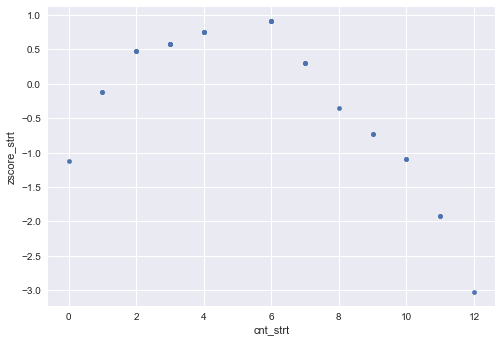

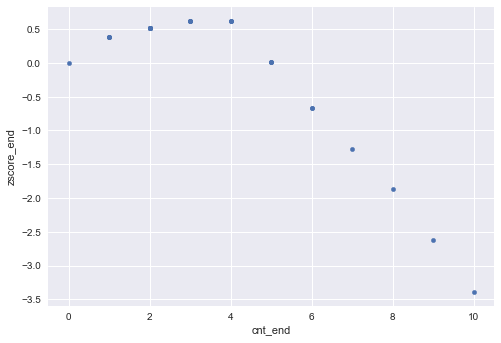

Site: 31209
Day: 4 Hour: 13 Week: 16
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-04-29 13:00:00       1.0      0.0 -7.000000e+09 -0.980000   
1  2011-05-06 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
2  2011-05-13 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
3  2011-05-20 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
4  2011-05-27 13:00:00       1.0      0.0 -7.000000e+09 -0.980000   
5  2011-06-03 13:00:00       1.0      5.0 -7.000000e+09 -3.472000   
6  2011-06-10 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
7  2011-06-17 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
8  2011-06-24 13:00:00       0.0      2.0 -1.000000e+00 -1.528000   
9  2011-07-01 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
10 2011-07-08 13:00:00       0.0      0.0 -1.000000e+00 -0.980000   
11 2011-07-15 13:00:00       4.0      2.0 -2.190000e+10 -1.528000   
12 2011-07-22 13:00:00       0.0      0.0 -1.000000e+00 -0.980000 

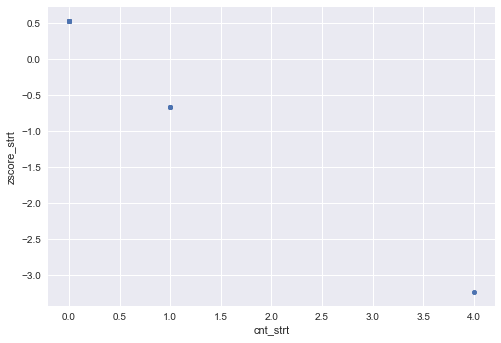

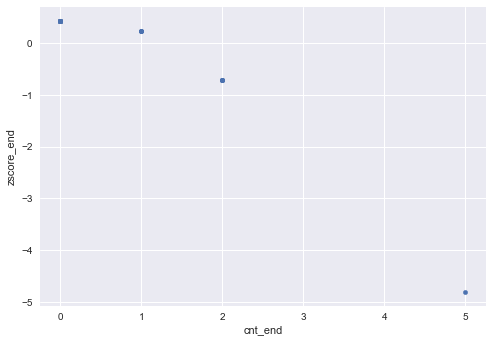

Site: 31226
Day: 4 Hour: 18 Week: 13
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-04-08 18:00:00       1.0      2.0  -0.981000 -1.011879     0.326214   
1  2011-04-15 18:00:00       1.0      3.0  -0.981000 -1.355428     0.326214   
2  2011-04-22 18:00:00       0.0      1.0  -1.085556 -1.002028     0.046565   
3  2011-04-29 18:00:00       3.0      0.0  -1.237630 -0.974314    -0.360179   
4  2011-05-06 18:00:00       2.0      1.0  -0.896786 -1.002028     0.551455   
5  2011-05-13 18:00:00       1.0      0.0  -0.981000 -0.974314     0.326214   
6  2011-05-20 18:00:00       2.0      1.0  -0.896786 -1.002028     0.551455   
7  2011-05-27 18:00:00       1.0      0.0  -0.981000 -0.974314     0.326214   
8  2011-06-03 18:00:00       0.0      2.0  -1.085556 -1.011879     0.046565   
9  2011-06-10 18:00:00       3.0      3.0  -1.237630 -1.355428    -0.360179   
10 2011-06-17 18:00:00       0.0      1.0  -1.085556 -1.002028     0.046565   
11 2011-06-24 1

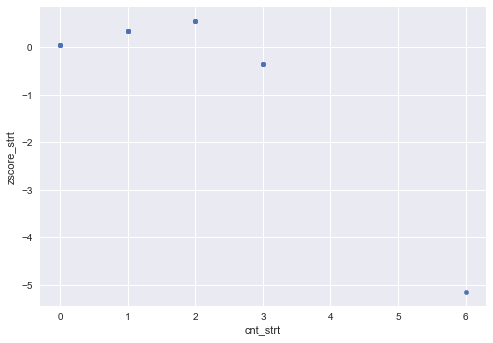

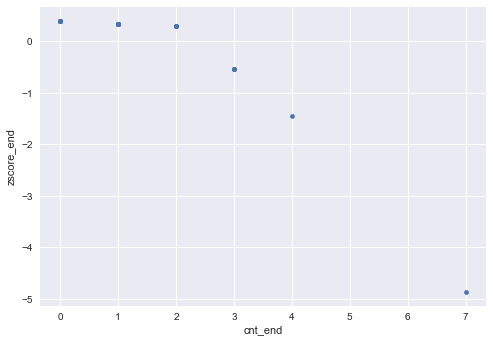

Site: 31607
Day: 5 Hour: 2 Week: 20
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-05-21 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
1  2011-05-28 02:00:00       0.0      1.0 -1.000000e+00 -1.033971   
2  2011-06-04 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
3  2011-06-11 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
4  2011-06-18 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
5  2011-06-25 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
6  2011-07-02 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
7  2011-07-09 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
8  2011-07-16 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
9  2011-07-23 02:00:00       0.0      1.0 -1.000000e+00 -1.033971   
10 2011-07-30 02:00:00       0.0      1.0 -1.000000e+00 -1.033971   
11 2011-08-06 02:00:00       0.0      0.0 -1.000000e+00 -0.986957   
12 2011-08-13 02:00:00       1.0      0.0 -9.975000e+09 -0.986957  

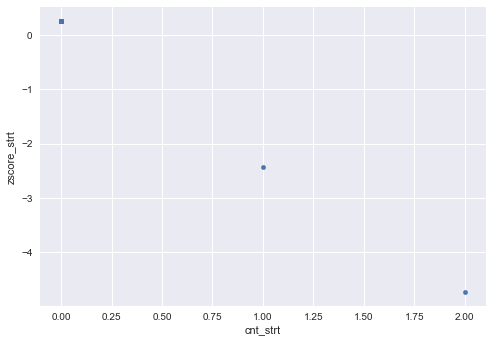

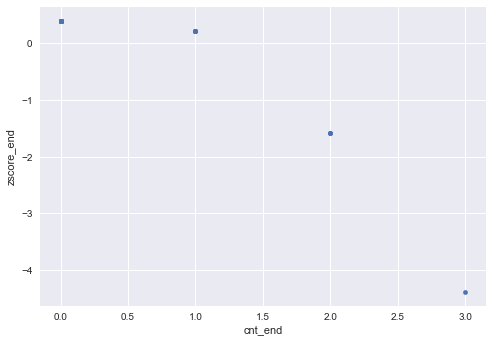

Site: 31600
Day: 3 Hour: 8 Week: 3
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-27 08:00:00       0.0      0.0  -1.181565 -1.043553    -2.027084   
1  2011-02-03 08:00:00       2.0      2.0  -1.070279 -0.972637    -0.558039   
2  2011-02-10 08:00:00       2.0      0.0  -1.070279 -1.043553    -0.558039   
3  2011-02-17 08:00:00       1.0      1.0  -1.114793 -1.008837    -1.145657   
4  2011-02-24 08:00:00       3.0      0.0  -1.025764 -1.043553     0.029580   
5  2011-03-03 08:00:00       2.0      0.0  -1.070279 -1.043553    -0.558039   
6  2011-03-10 08:00:00       0.0      0.0  -1.181565 -1.043553    -2.027084   
7  2011-03-17 08:00:00       6.0      1.0  -0.968075 -1.008837     0.791123   
8  2011-03-24 08:00:00       4.0      1.0  -0.996088 -1.008837     0.421325   
9  2011-03-31 08:00:00       4.0      0.0  -0.996088 -1.043553     0.421325   
10 2011-04-07 08:00:00      11.0      1.0  -0.989354 -1.008837     0.510223   
11 2011-04-14 08:

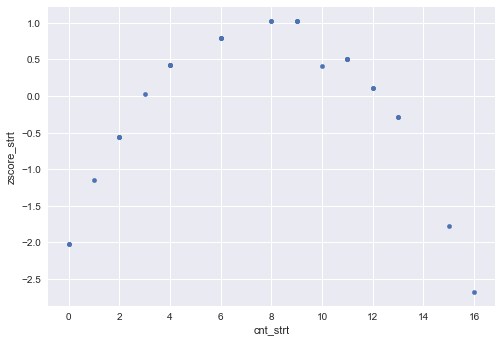

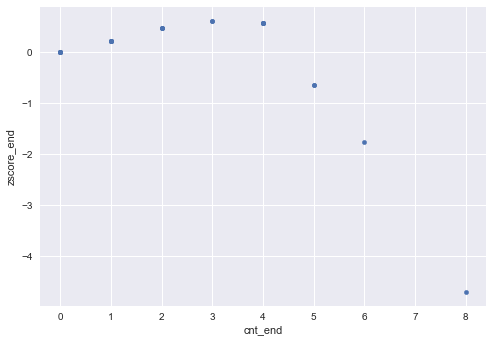

Site: 31502
Day: 6 Hour: 6 Week: 8
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-02-27 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
1  2011-03-06 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
2  2011-03-13 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
3  2011-03-20 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
4  2011-03-27 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
5  2011-04-03 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
6  2011-04-10 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
7  2011-04-17 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
8  2011-04-24 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
9  2011-05-01 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
10 2011-05-08 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
11 2011-05-15 06:00:00       0.0      0.0 -1.000000e+00      -1.0   
12 2011-05-22 06:00:00       1.0      0.0 -9.500000e+09      -1.0   

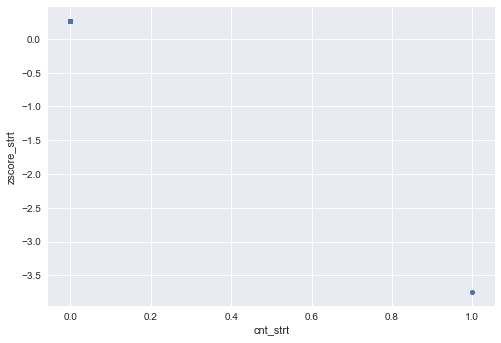

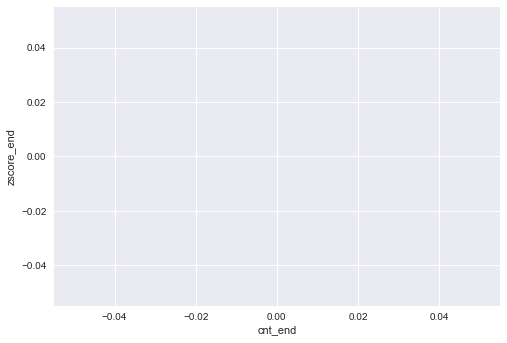

Site: 31205
Day: 1 Hour: 23 Week: 9
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-08 23:00:00       1.0      0.0  -1.017812 -0.980435     0.367323   
1  2011-03-15 23:00:00       1.0      0.0  -1.017812 -0.980435     0.367323   
2  2011-03-22 23:00:00       1.0      3.0  -1.017812 -2.258326     0.367323   
3  2011-03-29 23:00:00       0.0      0.0  -0.934783 -0.980435     0.479535   
4  2011-04-05 23:00:00       2.0      0.0  -1.312319 -0.980435    -0.030692   
5  2011-04-12 23:00:00       1.0      0.0  -1.017812 -0.980435     0.367323   
6  2011-04-19 23:00:00       2.0      0.0  -1.312319 -0.980435    -0.030692   
7  2011-04-26 23:00:00       0.0      0.0  -0.934783 -0.980435     0.479535   
8  2011-05-03 23:00:00       2.0      0.0  -1.312319 -0.980435    -0.030692   
9  2011-05-10 23:00:00       0.0      0.0  -0.934783 -0.980435     0.479535   
10 2011-05-17 23:00:00       1.0      0.0  -1.017812 -0.980435     0.367323   
11 2011-05-24 23

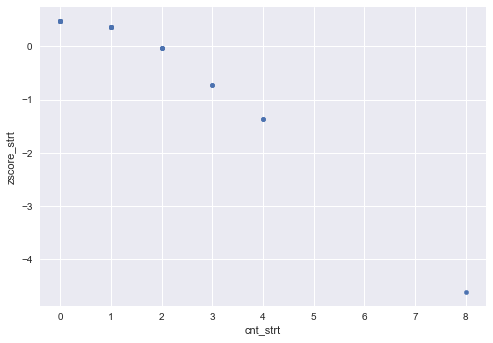

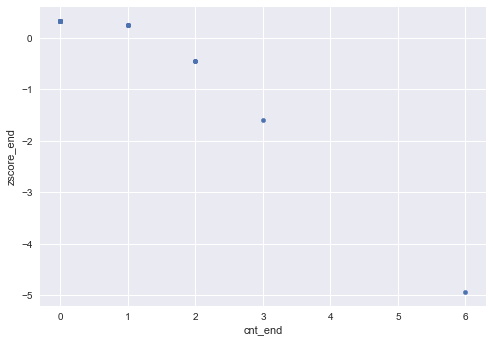

Site: 31016
Day: 4 Hour: 10 Week: 4
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-02-04 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-02-11 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-02-18 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-02-25 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-03-04 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-03-11 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-03-18 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-25 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-04-01 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-04-08 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-04-15 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-04-22 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-04-29 1

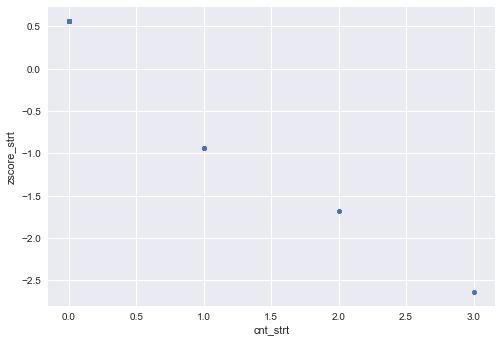

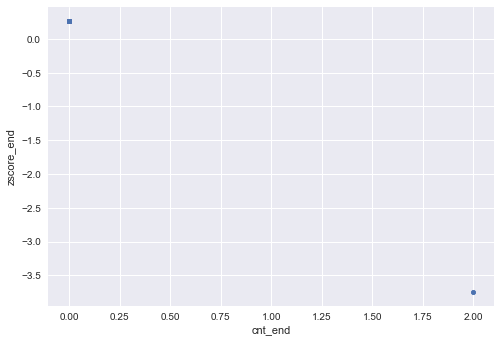

Site: 31112
Day: 1 Hour: 17 Week: 15
              datetime  cnt_strt  cnt_end     nlof_strt  nlof_end  \
0  2011-04-19 17:00:00       1.0      2.0 -8.800000e+09 -0.918919   
1  2011-04-26 17:00:00       0.0      0.0 -1.000000e+00 -1.112000   
2  2011-05-03 17:00:00       0.0      3.0 -1.000000e+00 -1.315365   
3  2011-05-10 17:00:00       0.0      1.0 -1.000000e+00 -0.965517   
4  2011-05-17 17:00:00       0.0      3.0 -1.000000e+00 -1.315365   
5  2011-05-24 17:00:00       0.0      2.0 -1.000000e+00 -0.918919   
6  2011-05-31 17:00:00       0.0      3.0 -1.000000e+00 -1.315365   
7  2011-06-07 17:00:00       0.0      3.0 -1.000000e+00 -1.315365   
8  2011-06-14 17:00:00       0.0      3.0 -1.000000e+00 -1.315365   
9  2011-06-21 17:00:00       2.0      0.0 -1.387500e+10 -1.112000   
10 2011-06-28 17:00:00       0.0      0.0 -1.000000e+00 -1.112000   
11 2011-07-05 17:00:00       1.0      0.0 -8.800000e+09 -1.112000   
12 2011-07-12 17:00:00       0.0      3.0 -1.000000e+00 -1.315365 

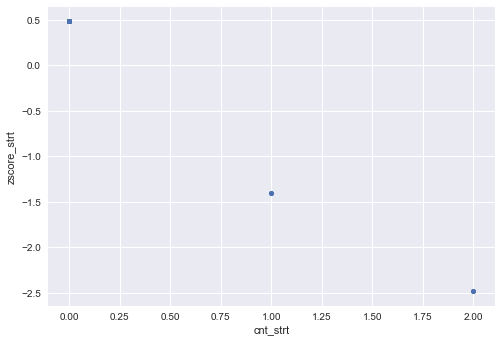

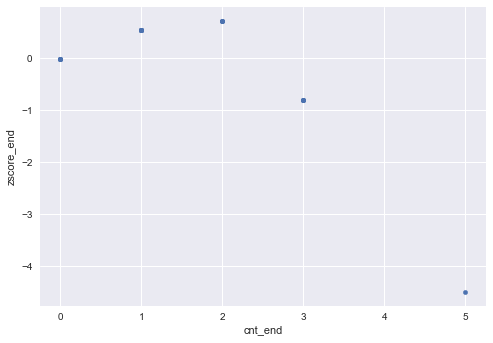

Site: 31244
Day: 3 Hour: 12 Week: 5
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-02-10 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-02-17 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-02-24 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-03-03 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-03-10 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-03-17 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-03-24 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-03-31 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-04-07 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-04-14 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-04-21 12:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-04-28 12

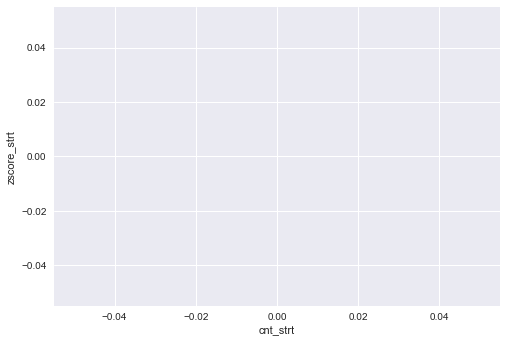

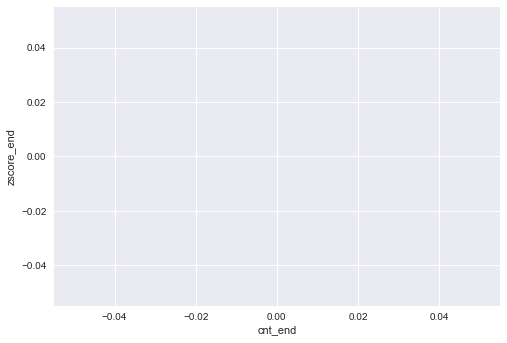

Site: 31007
Day: 2 Hour: 8 Week: 19
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-18 08:00:00       6.0      8.0  -0.968858 -0.984639     0.683241   
1  2011-05-25 08:00:00      12.0      8.0  -1.184808 -0.984639    -1.906029   
2  2011-06-01 08:00:00      12.0      8.0  -1.184808 -0.984639    -1.906029   
3  2011-06-08 08:00:00      10.0      8.0  -0.971910 -0.984639     0.646649   
4  2011-06-15 08:00:00       6.0      5.0  -0.968858 -0.998115     0.683241   
5  2011-06-22 08:00:00       5.0      7.0  -0.989708 -0.965241     0.433240   
6  2011-06-29 08:00:00       6.0      9.0  -0.968858 -1.015523     0.683241   
7  2011-07-06 08:00:00       7.0     10.0  -0.945291 -1.077293     0.965813   
8  2011-07-13 08:00:00       3.0      7.0  -1.051457 -0.965241    -0.307140   
9  2011-07-20 08:00:00       5.0      3.0  -0.989708 -1.155462     0.433240   
10 2011-07-27 08:00:00       4.0      9.0  -1.030675 -1.015523    -0.057959   
11 2011-08-03 08

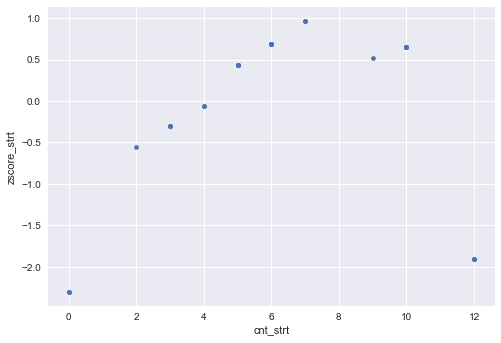

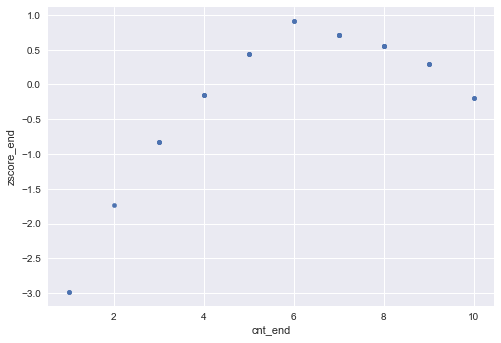

Site: 31701
Day: 5 Hour: 15 Week: 18
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-05-07 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-05-14 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-05-21 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-05-28 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-06-04 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-06-11 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-06-18 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-06-25 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-07-02 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-07-09 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-07-16 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-07-23 15:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-07-30 

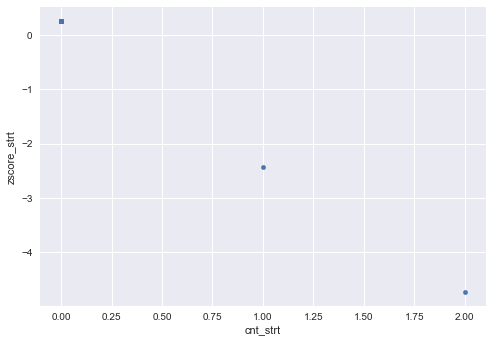

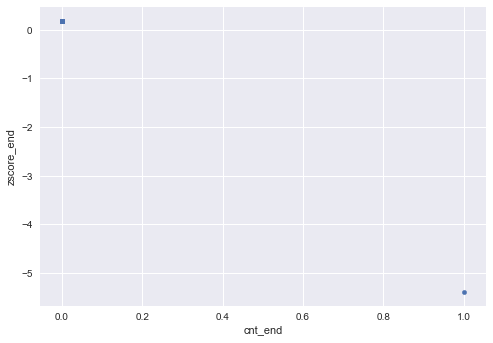

Site: 31227
Day: 3 Hour: 17 Week: 2
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-20 17:00:00       8.0      2.0  -0.961178 -0.986608     0.639471   
1  2011-01-27 17:00:00       3.0      0.0  -1.168365 -1.134822    -0.882397   
2  2011-02-03 17:00:00       6.0      2.0  -0.992920 -0.986608     0.406310   
3  2011-02-10 17:00:00       6.0      4.0  -0.992920 -0.980978     0.406310   
4  2011-02-17 17:00:00       8.0      0.0  -0.961178 -1.134822     0.639471   
5  2011-02-24 17:00:00       5.0      1.0  -1.012414 -0.981942     0.263121   
6  2011-03-03 17:00:00       7.0      1.0  -1.002667 -0.981942     0.334715   
7  2011-03-10 17:00:00       3.0      1.0  -1.168365 -0.981942    -0.882397   
8  2011-03-17 17:00:00      11.0      7.0  -0.978578 -1.317310     0.511657   
9  2011-03-24 17:00:00       7.0      4.0  -1.002667 -0.980978     0.334715   
10 2011-03-31 17:00:00       4.0      1.0  -1.080643 -0.981942    -0.238043   
11 2011-04-07 17

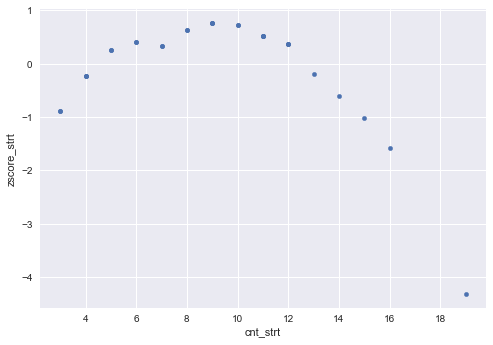

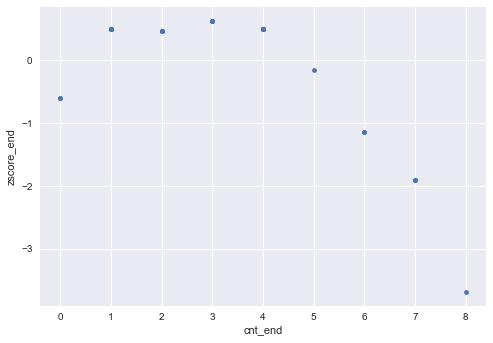

Site: 31217
Day: 3 Hour: 1 Week: 15
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-04-21 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-04-28 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-05-05 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-05-12 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-05-19 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-05-26 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-06-02 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-06-09 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-06-16 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-06-23 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-06-30 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-07-07 01:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-07-14 0

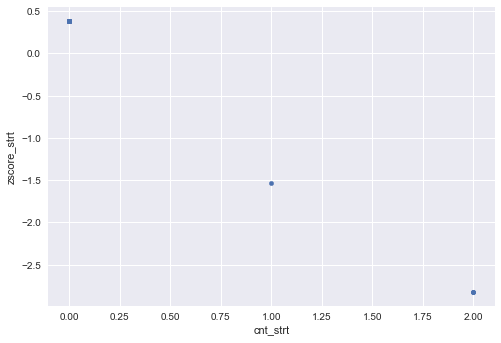

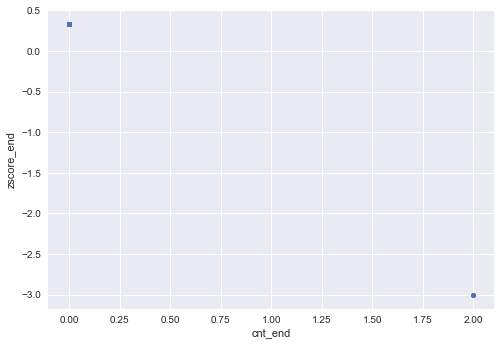

Site: 31700
Day: 2 Hour: 4 Week: 0
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-01-05 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-01-12 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-01-19 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-01-26 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-02-02 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-02-09 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-02-16 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-02-23 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-03-02 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-03-09 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-03-16 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-03-23 04:

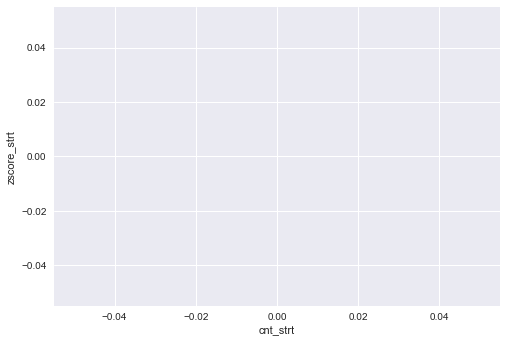

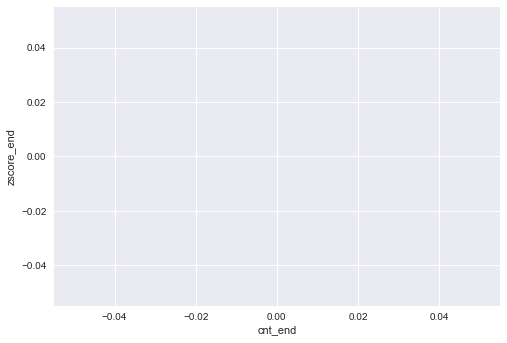

Site: 31015
Day: 1 Hour: 10 Week: 1
              datetime  cnt_strt  cnt_end     nlof_strt      nlof_end  \
0  2011-01-11 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
1  2011-01-18 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
2  2011-01-25 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
3  2011-02-01 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
4  2011-02-08 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
5  2011-02-15 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
6  2011-02-22 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
7  2011-03-01 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
8  2011-03-08 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
9  2011-03-15 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
10 2011-03-22 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
11 2011-03-29 10:00:00       0.0      0.0 -1.000000e+00 -1.000000e+00   
12 2011-04-05 1

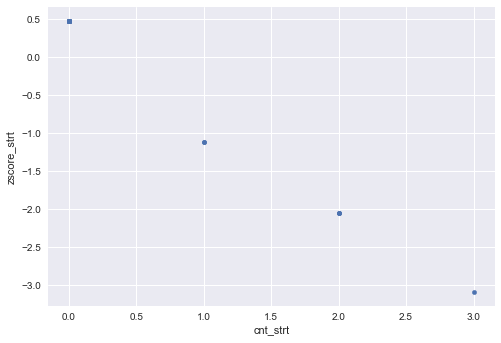

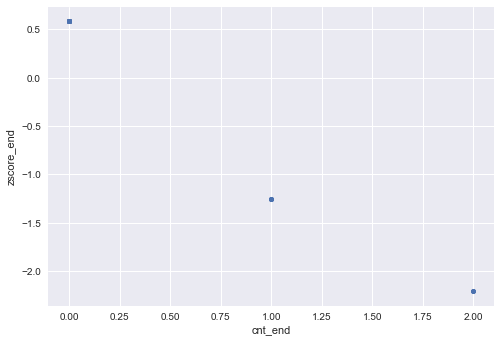

Site: 31206
Day: 0 Hour: 13 Week: 9
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-07 13:00:00       1.0      1.0  -1.033243 -0.975934     0.300095   
1  2011-03-14 13:00:00       1.0      1.0  -1.033243 -0.975934     0.300095   
2  2011-03-21 13:00:00       0.0      2.0  -0.986957 -0.913333     0.410349   
3  2011-03-28 13:00:00       0.0      3.0  -0.986957 -1.315125     0.410349   
4  2011-04-04 13:00:00       4.0      2.0  -2.884958 -0.913333    -4.110655   
5  2011-04-11 13:00:00       3.0      0.0  -2.227878 -1.129667    -2.545502   
6  2011-04-18 13:00:00       2.0      1.0  -1.570798 -0.975934    -0.980349   
7  2011-04-25 13:00:00       0.0      0.0  -0.986957 -1.129667     0.410349   
8  2011-05-02 13:00:00       0.0      1.0  -0.986957 -0.975934     0.410349   
9  2011-05-09 13:00:00       0.0      3.0  -0.986957 -1.315125     0.410349   
10 2011-05-16 13:00:00       0.0      1.0  -0.986957 -0.975934     0.410349   
11 2011-05-23 13

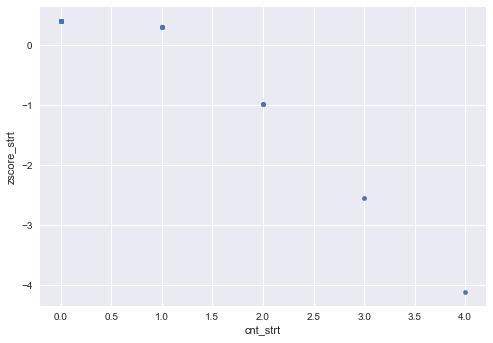

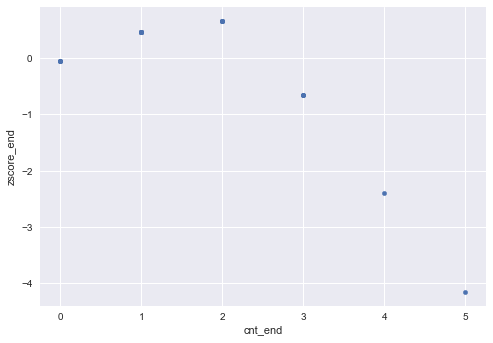

Site: 31020
Day: 6 Hour: 4 Week: 18
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-05-08 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-05-15 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-05-22 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-05-29 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-06-05 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-06-12 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-06-19 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-06-26 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-07-03 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-07-10 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-07-17 04:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-07-24 04

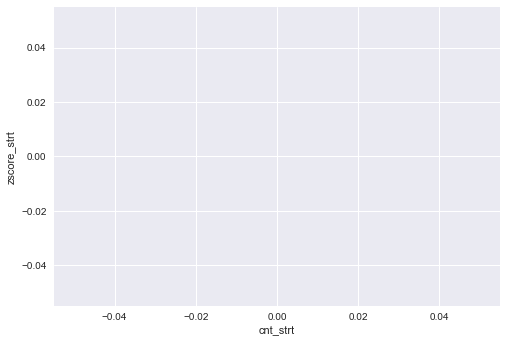

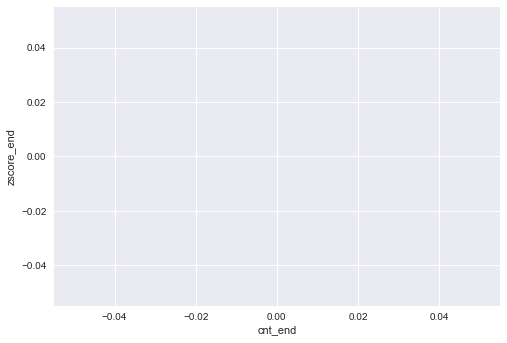

Site: 31222
Day: 4 Hour: 3 Week: 9
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-11 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-03-18 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-03-25 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-01 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-04-08 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-04-15 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-04-22 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-04-29 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-05-06 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-05-13 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-05-20 03:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-05-27 03:

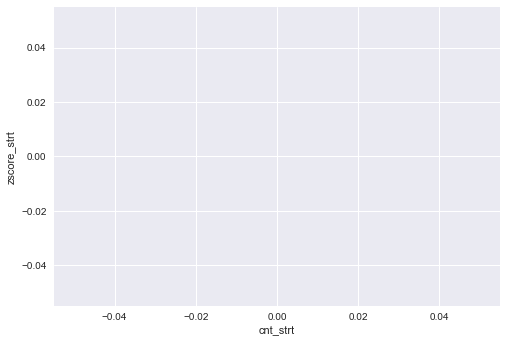

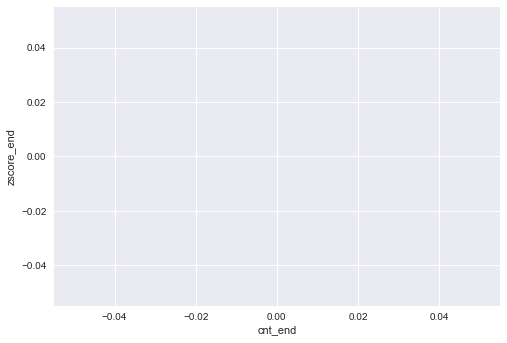

Site: 31262
Day: 1 Hour: 19 Week: 11
              datetime  cnt_strt  cnt_end  nlof_strt  nlof_end  zscore_strt  \
0  2011-03-22 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
1  2011-03-29 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
2  2011-04-05 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
3  2011-04-12 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
4  2011-04-19 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
5  2011-04-26 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
6  2011-05-03 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
7  2011-05-10 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
8  2011-05-17 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
9  2011-05-24 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
10 2011-05-31 19:00:00       0.0      0.0       -1.0      -1.0          NaN   
11 2011-06-07 1

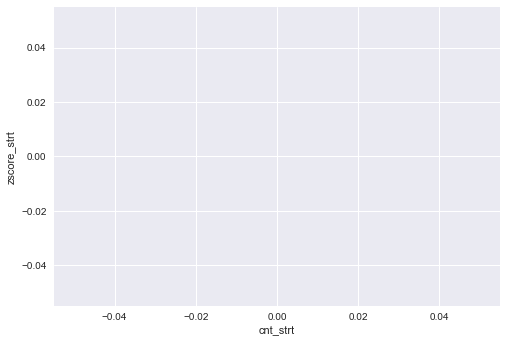

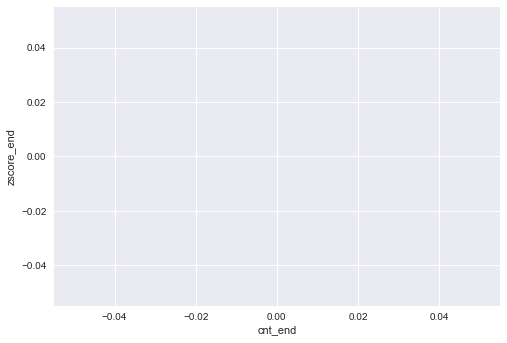

In [38]:
#get a random:
# - site
# - day of week (0 to 6)
# - hour of day (0 to 23)
# - window (week 0 to 21 - to get to end of year)
for i in np.arange(0,100):
    rand_site = sites[randint(0,len(sites)-1)]
    rand_d = randint(0,6)
    rand_h = randint(0,23)
    rand_w = randint(0,21)
   
    df_test_start = df_hourly_start[(df_hourly_start['dayofweek']==rand_d)&(df_hourly_start['hourofday']==rand_h)][rand_w:(rand_w+30)].fillna(0)
    df_test_end = df_hourly_end[(df_hourly_end['dayofweek']==rand_d)&(df_hourly_end['hourofday']==rand_h)][rand_w:(rand_w+30)].fillna(0)
   
    est_start = LocalOutlierFactor(n_neighbors=20,contamination=0.2)
    est_end = LocalOutlierFactor(n_neighbors=20,contamination=0.2)
    
    print('Site:',rand_site)
    print('Day:',rand_d,'Hour:',rand_h,'Week:',rand_w)
    
    X_start = df_test_start[rand_site].fillna(0)
    X_start_idx = X_start.index
    X_start_reshape = X_start.reshape(-1,1)
    y_pred_start = est_start.fit_predict(X_start_reshape)
    
    X_end = df_test_end[rand_site].fillna(0)
    X_end_idx = X_end.index
    X_end_reshape = X_end.reshape(-1,1)
    y_pred_end = est_end.fit_predict(X_end_reshape)
    
    neg_outlier_factor_start = est_start.negative_outlier_factor_
    neg_outlier_factor_end = est_end.negative_outlier_factor_
    
    zscore_lof_start = zscore(neg_outlier_factor_start)
    zscore_lof_end = zscore(neg_outlier_factor_end)
    
    df_test = pd.DataFrame(list(zip(X_start_idx,X_start,X_end,neg_outlier_factor_start,neg_outlier_factor_end,zscore_lof_start,zscore_lof_end)),columns=['datetime','cnt_strt','cnt_end','nlof_strt','nlof_end','zscore_strt','zscore_end'])
    print(df_test)
    df_test[['cnt_strt','cnt_end','zscore_strt','zscore_end']].plot(kind='scatter',x='cnt_strt',y='zscore_strt')
    df_test[['cnt_strt','cnt_end','zscore_strt','zscore_end']].plot(kind='scatter',x='cnt_end',y='zscore_end')
    plt.show()
